<a href="https://colab.research.google.com/github/quangtrongtran/DATN/blob/main/ICO_DATA4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **FINAL PROJECT**
## DỰ ĐOÁN GIÁ ICO SỬ DỤNG MACHINE LEARNING
![alt text](https://i.imgur.com/mFQhIcT.jpg)


### **CÁC PHẦN** 
- Import các tư viện cần thiết và viết các hàm cần thiết.
- Loading dataset vào trong biến.
- In ra biểu đồ phân tán thể hiện mối tương quan giữa các input với output.
- Mã hóa và phân chia dữ liệu.
- Sử dụng hồi quy đa biến thông thường để tính toán dự đoán kết quả => chứng sự ảnh hưởng của overfitting.
- Ridge Regression
  - Tìm ra model hồi quy có giá trị rMSE tốt nhất.
  - Tìm model hồi quy có giá trị R2 tốt nhất.
  - Load 2 model trên và tính toán hiệu năng.
  - Dự đoán giá ICO.
- Neural Network
  - Tìm ra model NN có giá trị rMSE tốt nhất.
  - Tìm model NN có giá trị R2 tốt nhất.
  - Load 2 model trên và tính toán hiệu năng.
  - Dự đoán giá ICO.

### **CÁC THƯ VIỆN VÀ FUNCTION CẦN THIẾT.**

### **CÁC THƯ VIỆN**

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)
#plt.style.use('ggplot') style="ticks",
import pandas as pd
from math import sqrt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
#import plotly.graph_objects as go

In [ ]:
from enum import Enum
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import os
from sklearn.preprocessing import OneHotEncoder
# from sklearn.externals import joblib
import joblib
from sklearn import decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from google.colab import files

### **FUNCTION**

In [ ]:
class LineaReggressionMetrics(Enum):
    R_SQUARED = 1
    ROOT_MEAN_SQUARED_ERROR = 2
    MEAN_ABSOLUTE_ERROR = 3

In [ ]:
class Solvers(Enum):
    lbfgs = 1
    sgd = 2
    adam = 3

In [ ]:
def load_Dataset1(dataset = './DATASET/ico_data_final.csv'):
    all_data = np.genfromtxt(fname=dataset, names=True, delimiter=',')
    #Lấy hết toàn bộ header trong dataset trả về kiểu chuỗi    
    featureNames = all_data.dtype.names[1:-1] 
    #Lấy hết toàn bộ tên của ico.
    ico_names = np.genfromtxt(fname=dataset, delimiter=',',skip_header=1, usecols=0, dtype=str)
    #Lấy hết toàn bộ giá trị trong dataset trừ header và tên ico
    all_data = np.genfromtxt(fname=dataset, delimiter=',',skip_header=1)[:,1:]
    #Lấy hết giá trị thuộc các thành phần output
    x = np.genfromtxt(fname=dataset, delimiter=',',skip_header=1)[:,1:-1]
    #Lấy hết giá trị output
    y = np.genfromtxt(fname=dataset, delimiter=',',skip_header=1)[:,-1]
    return (featureNames,x,y,ico_names)


In [ ]:
def load_Dataset2(path = './DATASET/ico_data_final.csv'):    
    dataset = pd.read_csv(path)
    x= dataset.iloc[:, 1:-1].values 
    data_com = dataset.iloc[:,1:15].values
    print(data_com)
    #Lấy giá trị cột cuối
    y= dataset.iloc[:,14].values
    icoNames = dataset.iloc[:,0]
    featureNames = list(dataset.columns[1:-1])
    return (featureNames, x, y, icoNames, data_com)

In [ ]:
def createFolderIfDoesntExist(folderName):
    exists = os.path.isdir(folderName)
    if not exists:
        os.makedirs(folderName)
        
    return exists

In [ ]:
# Tải dataset từ Github
def loadDataFromGithub(fileName='./DATASET/ico_data_final.csv'):
    exists = os.path.isfile(fileName)
    if not exists:
      !wget https://raw.githubusercontent.com/quangtrongtran/DATN/main/ico_data_final.csv -P "./DATASET/"

In [ ]:
def loadModel(fileName):
    exists = os.path.isfile(fileName)
    if exists:    
        # Tải model nếu nó tồn tại
        return joblib.load(fileName)
    else:
        return None

In [ ]:
def createResultsFolderIfDoesntExist(folder):
    folderExists = createFolderIfDoesntExist(folder)
    #if not folderExists:
      #download best models from github 
      #!wget https://raw.githubusercontent.com/daominhthuan42/ICO_FINAL/master/BEST_MODEL/bestRegressionModel_Ridge_ROOT_MEAN_SQUARED_ERROR.sav -P "./RESULT/"
      #!wget https://raw.githubusercontent.com/daominhthuan42/ICO_FINAL/master/BEST_MODEL/bestRegressionModel_Ridge_R_SQUARED.sav -P "./RESULT/"
      #!wget https://raw.githubusercontent.com/daominhthuan42/ICO_FINAL/master/BEST_MODEL/bestRegressionModel_Ridge_MEAN_ABSOLUTE_ERROR.sav -P "./RESULT/"
      #!wget https://raw.githubusercontent.com/daominhthuan42/ICO_FINAL/master/BEST_MODEL/bestNNModel_MEAN_ABSOLUTE_ERRORsgd.sav -P "./RESULT/"
      #!wget https://raw.githubusercontent.com/daominhthuan42/ICO_FINAL/master/BEST_MODEL/bestNNModel_ROOT_MEAN_SQUARED_ERRORsgd.sav -P "./RESULT/"
      #!wget https://raw.githubusercontent.com/daominhthuan42/ICO_FINAL/master/BEST_MODEL/bestNNModel_R_SQUAREDsgd.sav -P "./RESULT/"       

In [ ]:
"""
HÀM NÀY LÀ SẼ IN RA PLOT MONG MUỐN VÀ PLOT DỰ ĐOÁN
"""
def plotExpectedVsPredictedOutput(y_test, y_pred, fileName='', saveToFile=False):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(y_test, y_pred, c = "blue", label = "y_pred")
    ax.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--', lw=2)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.legend(loc="upper left")
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.title(fileName)
    if(saveToFile == True):
        createFolderIfDoesntExist("IMAGE_RESULT/")
        plt.savefig('IMAGE_RESULT/'+fileName+".png", dpi = 300)
    else: 
        plt.show()

In [ ]:
"""
HÀM NÀY LÀ SẼ IN RA PLOT MONG MUỐN VÀ PLOT DỰ ĐOÁN
"""
def plotExpectedVsPredictedOutput2(y_test, y_pred, fileName='', saveToFile = True):
    plt.subplots(figsize=(6,6))    
    plt.xlabel('y_pred')
    plt.ylabel('y_test_holdout')   
    sns.regplot(y_pred, y_test)    
    plt.title(fileName)
    if(saveToFile == True):
        createFolderIfDoesntExist("IMAGE_RESULT/")
        plt.savefig('IMAGE_RESULT/'+fileName+".png", dpi = 300)    
    plt.show()

In [ ]:
def line_plot(line1, line2, label1= 'actual', label2= 'prediction', title='', lw=2, saveToFile = True):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1,'-o',  color='darkorange', label=label1, linewidth=lw)
    ax.plot(line2, '-s', color='navy', label=label2, linewidth=lw)   
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    if(saveToFile == True):
        createFolderIfDoesntExist("IMAGE_LINE_PLOT/")
        plt.savefig('IMAGE_LINE_PLOT/'+title+".png", dpi = 500)
    plt.show()

In [ ]:
def line_plot2(line, lw = 2, saveToFile= True, title='', label1=''):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.plot(line,  color='darkorange', label=label1, linewidth=lw)    
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    if(saveToFile == True):
        createFolderIfDoesntExist("OPTIMIZE/")
        plt.savefig('OPTIMIZE/'+title+".png", dpi = 300)
    plt.show()

In [ ]:
def plotResult(y_test_hodlout, y_pred_rMSE, y_pred_R2, y_pred_MAE, saveToFile = True, rMSE = '', R2= '', MAE = ''):
  f, ax = plt.subplots(figsize=(10, 7), nrows=3)  
  f.tight_layout()
  ax[0].plot(y_pred_rMSE, '-s', color='navy', label='Predicted Values', linewidth = 1);
  ax[0].plot(y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1);
  ax[0].set_title("Predicted vs Actuals Using Best model rMSE: " + rMSE)
  ax[0].legend(loc='best')

  ax[1].plot(y_pred_R2, '-s', color='navy', label='Predicted Values', linewidth = 1);
  ax[1].plot(y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1);
  ax[1].set_title("Predicted vs Actuals Using Best model R2: "+R2)
  ax[1].legend(loc='best')

  ax[2].plot(y_pred_MAE, '-s', color='navy', label='Predicted Values', linewidth = 1);
  ax[2].plot(y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1);
  ax[2].set_title("Predicted vs Actuals Using Best model MAE: "+ MAE)
  ax[2].legend(loc='best')
  if(saveToFile == True):
      createFolderIfDoesntExist("LINE_PLOT_3/")
      plt.savefig('LINE_PLOT_3/'+"PLOT_RESULT"+".png", dpi = 300)

In [ ]:
def plotResult2(y_test_hodlout, y_pred_Ridge_rMSE, y_pred_Ridge_R2, y_pred_Ridge_MAE, y_pred_NN_rMSE, 
                y_pred_NN_R2, y_pred_NN_MAE, saveToFile = True, solver = Solvers.lbfgs):
  f, ax = plt.subplots(figsize=(15, 10), nrows=6)   
  f.tight_layout()
  ax[0].plot(range(len(y_pred_Ridge_rMSE)), y_pred_Ridge_rMSE, '-s', color='navy', label='Predicted Values', linewidth = 1);
  ax[0].plot(range(len(y_pred_Ridge_rMSE)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1);
  ax[0].set_title("Predicted vs Actuals Using Best model rMSE Ridge")
  ax[0].legend(loc='best')

  ax[1].plot(range(len(y_pred_Ridge_R2)), y_pred_Ridge_R2, '-s', color='navy', label='Predicted Values', linewidth = 1);
  ax[1].plot(range(len(y_pred_Ridge_R2)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1);
  ax[1].set_title("Predicted vs Actuals Using Best model R2 Ridge")
  ax[1].legend(loc='best')

  ax[2].plot(range(len(y_pred_Ridge_MAE)), y_pred_Ridge_MAE, '-s', color='navy', label='Predicted Values', linewidth = 1);
  ax[2].plot(range(len(y_pred_Ridge_MAE)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1);
  ax[2].set_title("Predicted vs Actuals Using Best model MAE Ridge")
  ax[2].legend(loc='best')

  ax[3].plot(range(len(y_pred_NN_rMSE)), y_pred_NN_rMSE, '-s', color='navy', label='Predicted Values', linewidth = 1);
  ax[3].plot(range(len(y_pred_NN_rMSE)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1);
  ax[3].set_title("Predicted vs Actuals Using Best model rMSE NN " + str(solver.name))
  ax[3].legend(loc='best')

  ax[4].plot(range(len(y_pred_NN_R2)), y_pred_NN_R2, '-s', color='navy', label='Predicted Values', linewidth = 1);
  ax[4].plot(range(len(y_pred_NN_R2)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1);
  ax[4].set_title("Predicted vs Actuals Using Best model R2 NN " + str(solver.name))
  ax[4].legend(loc='best')

  ax[5].plot(range(len(y_pred_NN_MAE)), y_pred_NN_MAE, '-s', color='navy', label='Predicted Values', linewidth = 1);
  ax[5].plot(range(len(y_pred_NN_MAE)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1);
  ax[5].set_title("Predicted vs Actuals Using Best model MAE NN " + str(solver.name))
  ax[5].legend(loc='best')  
  if(saveToFile == True):
      createFolderIfDoesntExist("LINE_PLOT_6/")
      plt.savefig('LINE_PLOT_6/'+"PLOT_RESULT"+".png", dpi = 300)

In [ ]:
def plotPredicted(rMSE, R2, MAE):
  plt.figure(figsize=(10, 5))
  ax1 = plt.subplot(311, title ='Price ICO 0x, modum and crypto20 using best model rMSE')
  ax1.hist(rMSE)
  ax2 = plt.subplot(312,sharex=ax1, title ='Price ICO 0x, modum and crypto20 using best model R2')
  ax2.hist(R2)
  ax3 = plt.subplot(313,sharex=ax1, title ='Price ICO 0x, modum and crypto20 using best model MAE')
  ax3.hist(MAE)
  plt.tight_layout()

In [ ]:
def printPlotCoef(feauteNames, model):
    d = model.coef_[0:13]
    print("Hệ số: ", d)
    print("Input: ", feauteNames) 
    data = { feauteNames[0]: d[0], feauteNames[1]: d[1], feauteNames[2]: d[2], feauteNames[3]: d[3], feauteNames[4]: d[4], feauteNames[5]: d[5], feauteNames[6]: d[6],
            feauteNames[7]: d[7], feauteNames[8]: d[8], feauteNames[9]: d[9], feauteNames[10]: d[10], feauteNames[11]: d[11], feauteNames[12]: d[12]}  
    coef = pd.Series(data)
    plt.figure(figsize=(10, 5))
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    coef.head(13).plot(kind='bar')
    plt.title('Feature Significance')
    plt.tight_layout()    

In [ ]:
"""
HÀM TÍNH TOÁN DỰ ĐOÁN KẾT QUẢ
"""        
def makePrediction(model,example_to_predict):
    encoded_x, encodedCategoryArray = encodeSingleElement(x,example_to_predict)
    y_pred = model.predict(encoded_x.reshape(1, -1))
    
    return y_pred

In [ ]:
"""
HÀM TÍNH TOÁN RA HỆ SỐ TƯƠNG QUAN GIỮA CÁC BIẾN VÀ SỬ DỤNG BIỂU ĐỒ
PHÂN TÁN ĐỂ THỂ HIỆN SỰ TUYẾN TÍNH GIỮA 2 BIẾN.
"""
def getCovarianceMatrixAndPrintScatterPlot(x, y, saveToFile=True):
    nrows = x.shape[0] #trả về sô hàng
    ncols = x.shape[1] # trả về số vột 

    for i in np.arange(ncols):
        corCoef = np.corrcoef(x[:,i], y) 
        plt.xlabel(featureNames[i])
        plt.ylabel("Price after 6 months ($) ")
        plt.suptitle('Scatter Plot of feature {:s} vs Price after 6 months'.format(featureNames[i]))
        corr = "Correlation Coefficient: "+str(corCoef[0,1])
        plt.title(corr)
        plt.scatter(x[:,i], y)
        if(saveToFile == True):
            exist= createFolderIfDoesntExist("IMAGE_SCATTER/")
            plt.savefig('IMAGE_SCATTER/{:s}_vs_Price_scatter_plot.png'.format(featureNames[i]), dpi = 300)                    
            plt.show()
        
        plt.clf() 

### **TẠO CÁC FOLDER CẦN THIẾT**

TẠO FOLDER RESULT, TRONG FOLDER NÀY SẼ CHỨA CÁC MODEL 

In [ ]:
createResultsFolderIfDoesntExist("RESULT/")

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

TẢI DATASET VỀ TỪ GITHUB

In [ ]:
loadDataFromGithub()

--2021-06-09 11:07:29--  https://raw.githubusercontent.com/quangtrongtran/DATN/main/ico_data_final.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11877 (12K) [text/plain]
Saving to: ‘./DATASET/ico_data_final.csv’

ico_data_final.csv  100%[===================>]  11.60K  --.-KB/s    in 0s      

2021-06-09 11:07:30 (109 MB/s) - ‘./DATASET/ico_data_final.csv’ saved [11877/11877]



### **LOADING ICO DATASET VÀO TRONG BIẾN**

In [ ]:
(featureNames, x, y, icoNames, data_com) = load_Dataset2()

[[1.7145600e+00 1.9931000e-04 1.0000000e+09 ... 9.0000000e+00
  1.8200000e+02 1.0800000e+00]
 [1.2293200e+00 1.4290000e-04 2.0000000e+07 ... 1.0000000e+00
  2.8000000e+01 2.1900000e+00]
 [2.3553500e-01 2.7380000e-05 1.3027102e+08 ... 1.6000000e+01
  5.1000000e+01 9.0026900e-01]
 ...
 [1.0328300e+00 1.2006000e-04 9.9218023e+07 ... 2.8000000e+01
  1.5500000e+02 2.8900000e+00]
 [6.7163900e+00 7.8075000e-04 2.1000000e+08 ... 3.0000000e+00
  1.8200000e+02 3.2000000e+00]
 [2.5667400e-01 2.9840000e-05 1.8500000e+09 ... 1.5000000e+01
  2.9000000e+01 2.7435000e-01]]


### **HỆ SỐ TƯƠNG QUAN GIỮA CÁC INPUT VỚI OUTPUT**
Hệ số tương quan thê hiển độ quan hệ tuyến tính giữa 2 biến không phân biệt biến này phụ thuộc biến kia.

**Đặc tính:**
 - Hệ số tương quan không có đơn vị.
 - Nằm trong khoàng [-1,1].

  ![alt text](https://i.imgur.com/72RWtXW.png)
 - r > 0: Tương quan dương.
 - r < 0: Tương quan âm.
 - r = 0: Không tương quan.
 Đánh giá tương quan giữa 2 biến định lượng.

 ![alt text](https://i.imgur.com/JpGBUGC.png)

 

TÍNH TOÁN HỆ SỐ TƯƠNG QUAN GIỮA CÁC INPUT VỚI OUPUT ĐỂ HIỂU HƠN VỀ DỮ LIỆU

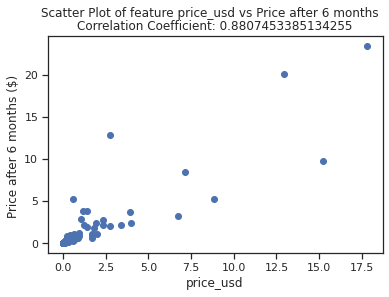

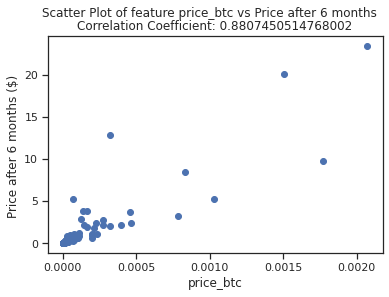

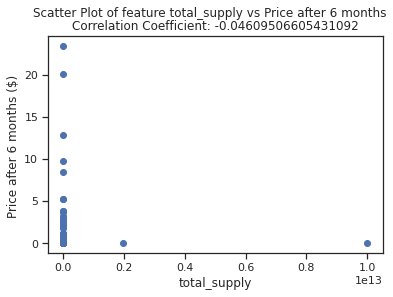

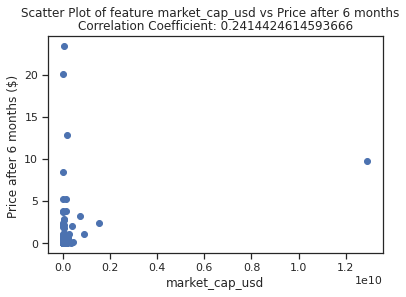

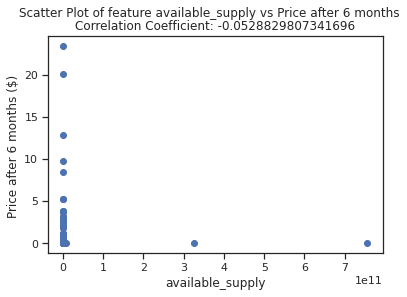

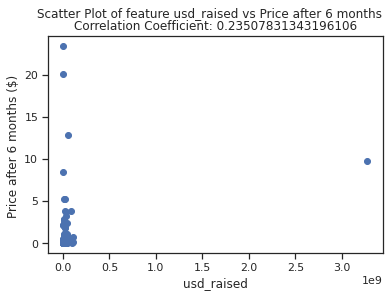

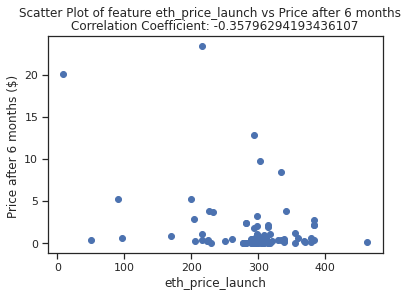

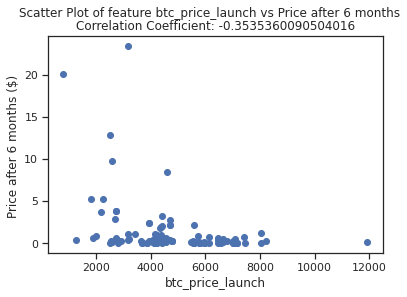

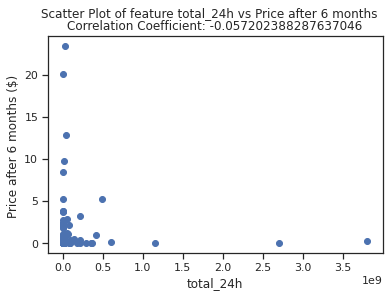

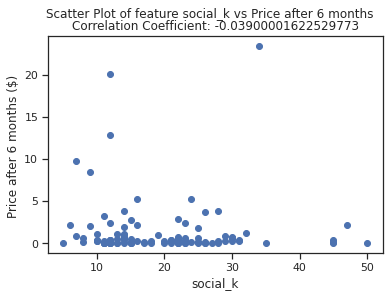

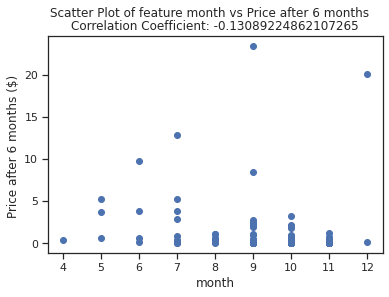

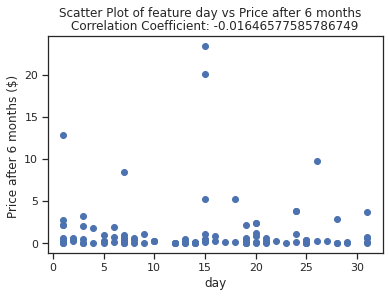

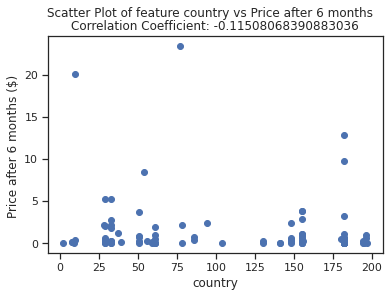

<Figure size 432x288 with 0 Axes>

In [ ]:
getCovarianceMatrixAndPrintScatterPlot(x, y)

Biểu đồ bên dưới thể hiện được sự đa cộng tuyến, cụ thể là các input có sự tương quan cao, các số tương quan cao đó sẽ được nổi bật lên.
![alt text](https://i.imgur.com/In7lpb4.png)


Biểu đồ thể hiện đầy đủ sự tương quan giữa input với input và giữa input với output
![alt text](https://i.imgur.com/SqrTYVL.png)

Biểu đồ thể hiện sự tương quan giữa các biến sử dụng python

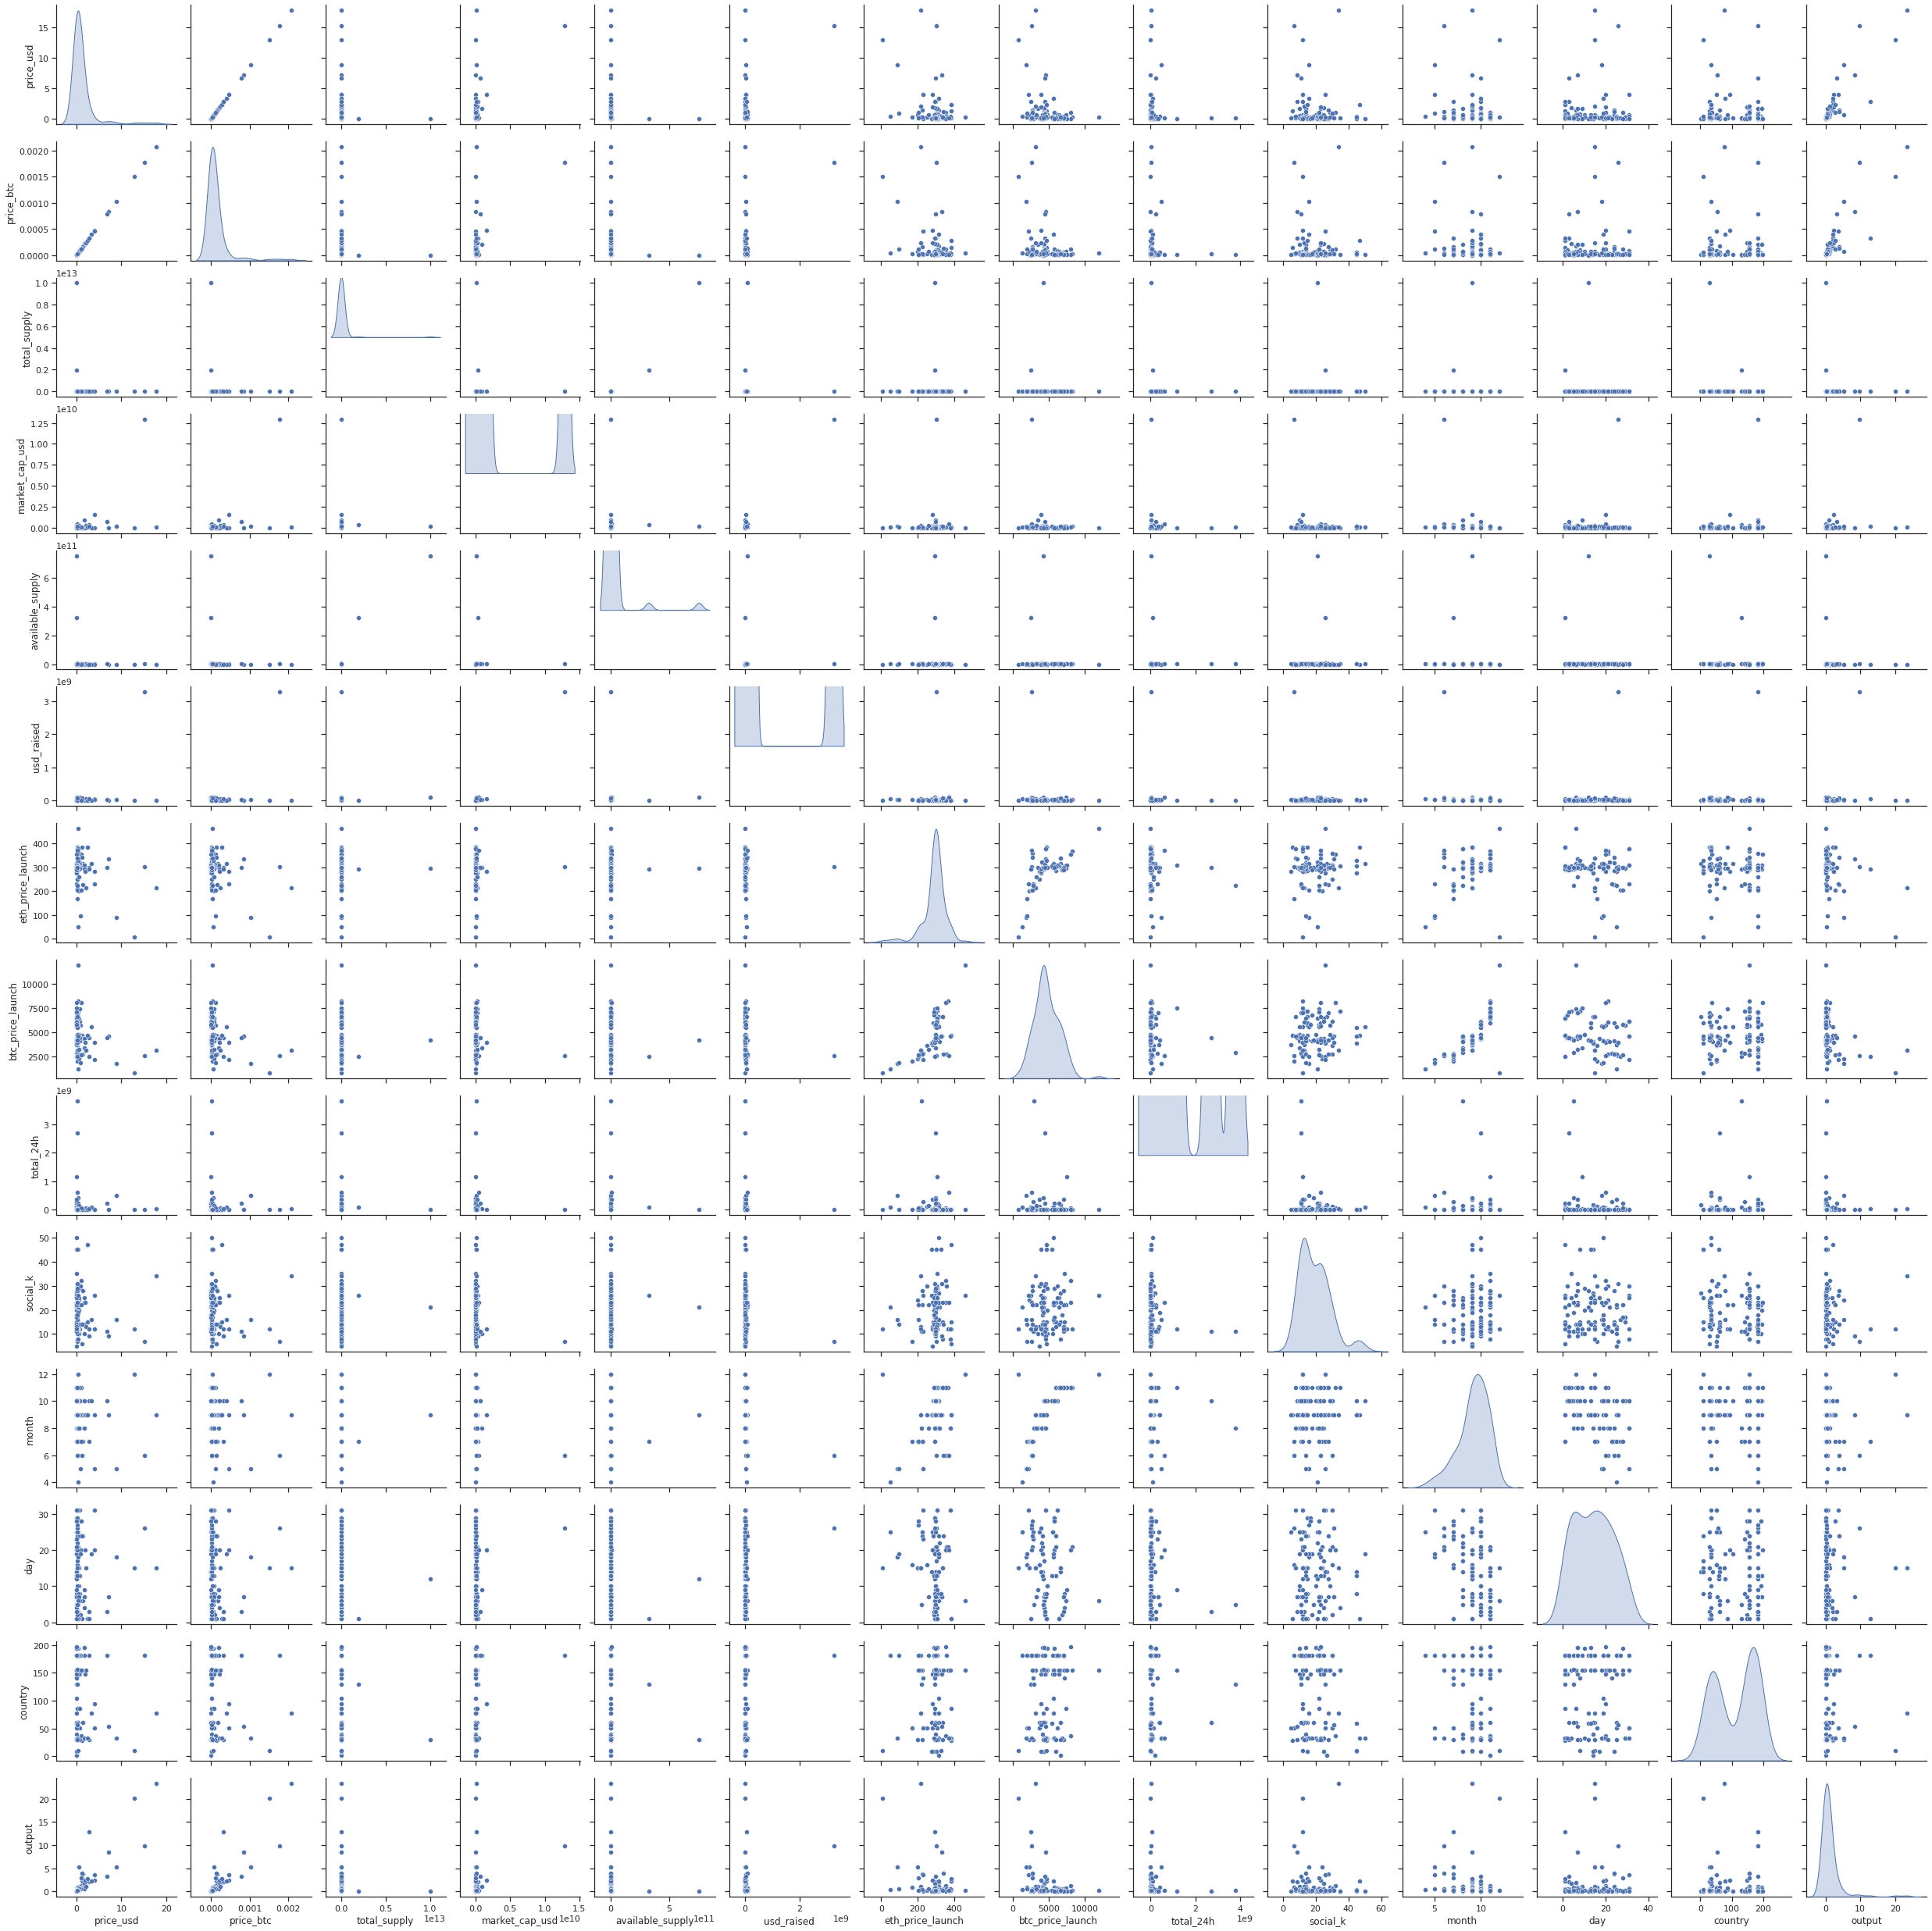

In [ ]:
data = pd.DataFrame(data_com, columns= ["price_usd","price_btc","total_supply","market_cap_usd","available_supply","usd_raised","eth_price_launch","btc_price_launch","total_24h","social_k","month","day","country","output"])
g = sns.pairplot(data, palette="husl",  diag_kind="kde")

### BẢNG PHÂN TÍCH TƯƠNG QUAN

In [ ]:
data.corr(method ='pearson') 

,price_usd,price_btc,total_supply,market_cap_usd,available_supply,usd_raised,eth_price_launch,btc_price_launch,total_24h,social_k,month,day,country,output
price_usd,1.000000,1.000000,-0.047804,0.503084,-0.054586,0.479698,-0.322412,-0.317538,-0.040502,-0.078939,-0.147879,0.013461,-0.090223,0.880745
price_btc,1.000000,1.000000,-0.047804,0.503085,-0.054585,0.479698,-0.322411,-0.317548,-0.040515,-0.078933,-0.147886,0.013466,-0.090227,0.880745
total_supply,-0.047804,-0.047804,1.000000,-0.002465,0.977275,0.011383,0.005761,-0.052615,-0.020754,0.027311,-0.035105,-0.052335,-0.113829,-0.046095
market_cap_usd,0.503084,0.503085,-0.002465,1.000000,0.000642,0.989104,0.017250,-0.138064,-0.020143,-0.147864,-0.203643,0.110983,0.108991,0.241442
available_supply,-0.054586,-0.054585,0.977275,0.000642,1.000000,0.007980,0.006848,-0.075286,-0.020071,0.040497,-0.060686,-0.079537,-0.100761,-0.052883
usd_raised,0.479698,0.479698,0.011383,0.989104,0.007980,1.000000,0.015393,-0.127289,-0.022589,-0.133001,-0.204329,0.131001,0.099634,0.235078
eth_price_launch,-0.322412,-0.322411,0.005761,0.017250,0.006848,0.015393,1.000000,0.615691,-0.099094,0.098448,0.395058,-0.183897,-0.000494,-0.357963
btc_price_launch,-0.317538,-0.317548,-0.052615,-0.138064,-0.075286,-0.127289,0.615691,1.000000,-0.082804,0.107360,0.798111,-0.192610,0.055256,-0.353536
total_24h,-0.040502,-0.040515,-0.020754,-0.020143,-0.020071,-0.022589,-0.099094,-0.082804,1.000000,-0.146851,-0.046184,-0.152381,-0.020597,-0.057202
social_k,-0.078939,-0.078933,0.027311,-0.147864,0.040497,-0.133001,0.098448,0.107360,-0.146851,1.000000,0.047995,-0.019046,-0.217928,-0.039000


Biểu đồ tương quan thể hiện bằng màu sắc.

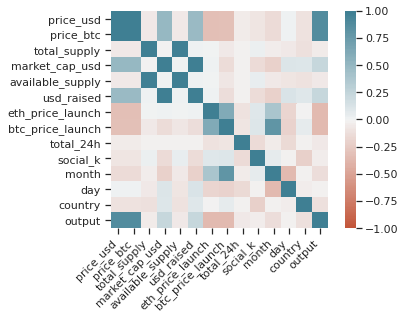

In [ ]:
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### **MÃ HÓA VÀ PHÂN CHIA DỮ LIỆU**
Sử dụng one hot encoding để mã hóa các trường dữ liệu: Social, ICO Date, ICO month launched and ICO country.

In [ ]:
"""
MÃ HÓA VÀ PHÂN LOẠI DỮ LIỆU VÀ PHÂN LOẠI DỮ LIỆU
"""
def encodeData(x):
    enc = OneHotEncoder(handle_unknown='error', sparse=False)
    # Mã hóa one hot cho 4 4 trường dữ liệu ICO Date, ICO month launched and ICO country.
    encodedCategoryArray= enc.fit_transform(x[:,10:13])
    # Loại bỏ 4 trường dữ liệu đó từ dataset.
    allInputsExceptCategorical = np.delete(x, np.s_[10:13], axis=1)
    # Ghép các input còn lại với các trường mã hóa.
    encodedX = np.concatenate((allInputsExceptCategorical,encodedCategoryArray),axis=1)
    return encodedX

def encodeSingleElement(x, sample):
    enc = OneHotEncoder(handle_unknown='error', sparse=False)

    encodedCategoryArray= enc.fit(x[:,10:13])
    allInputsExceptCategorical = np.delete(sample, np.s_[10:13], axis=0)
    
    encodedCategories  = enc.transform(sample[10:13].reshape(1, -1))
    encodedX = np.concatenate((allInputsExceptCategorical,encodedCategories.flatten()),axis=0)
    return (encodedX, encodedCategoryArray)

In [ ]:
encodeX = encodeData(x)

### **CHIA DATASET THÀNH TẬP TRAIN VÀ TẬP TEST**
80% cho tập train và 20% cho tập test. Sau đó trong tập train cũng chia 80/20 để tính toán.

In [ ]:
X_cross, X_test_holdout, y_cross, y_test_holdout = train_test_split(encodeX, y, test_size=0.2, random_state = 42)

# **Ridge Regession**

---


Chia dữ liệu thành 80/20 từ trập train Ridge Regression

In [ ]:
def ridgeRegression(x, y):       
    X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
    regressor_Ridge = linear_model.RidgeCV(gcv_mode='svd', alphas = [0.6, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 10],
                                            normalize=True)
    regressor_Ridge.fit(X_train, y_train) 

    bestRegressionCoef_Ridge = regressor_Ridge.coef_    
    y_pred_Ridge = regressor_Ridge.predict(X_val)
    
    r2_Ridge = r2_score(y_val, y_pred_Ridge)    
    rMeanSquaredError_Ridge = sqrt(mean_squared_error(y_val, y_pred_Ridge))
    meanAbsoluteError = mean_absolute_error(y_val, y_pred_Ridge)  
      
    return (regressor_Ridge, rMeanSquaredError_Ridge, r2_Ridge, meanAbsoluteError, bestRegressionCoef_Ridge)

MỘT DẠNG KHÁC TỐI ƯU THÔNG SỐ RIDGE MÀ KHÔNG CẦN PHẢI PHÂN TÍCH DỮ LIỆU.
KẾT HỢP PIELINE VÀ PCA. NHƯNG THƯ VIỆN GGCOLAB BÁO LỖI.CHẠY DƯỚI LOCAL THÌ KHÔNG CÓ LỖI.

In [ ]:
def ridgeRegression2(x,y):
    X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
    ridge = linear_model.Ridge()
    sc = StandardScaler()
    # TẠO 1 ĐỐI TƯỢNG PCA
    pca = decomposition.PCA() 
    pipe = Pipeline(steps=[('sc', sc),
                       ('pca', pca),
                       ('ridge', ridge)])
    n_components = list(range(1, X_train.shape[1] + 1, 1))    
    normalize = [True, False ]
    solver = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    parameters = dict(pca__n_components=n_components,
                  ridge__normalize=normalize,
                  ridge__solver=solver)
    clf = GridSearchCV(pipe, parameters)
    # Fit the grid search
    regressor = clf.fit(X_train, y_train)       
    y_pred = regressor.predict(X_val)   
    #print('Best Number Of Components:', clf.best_estimator_)
    print(); print(clf.best_estimator_.get_params()['ridge'])  
    r2 = r2_score(y_val, y_pred)
    rMeanSquaredError = sqrt(mean_squared_error(y_val, y_pred))    
    coefRidge = clf.best_estimator_.named_steps['ridge'].coef_
    return (regressor, rMeanSquaredError, r2, coefRidge)   

## **TÍNH TOÁN TRAINING ERROR VÀ TEST ERROR**
Tim hiểu xem model có bị hiện tượng overfitting

In [ ]:
def trainingError(x,y):   
    regressor = linear_model.LinearRegression()
    regressor.fit(x, y)  
    y_pred_training = regressor.predict(x)
    trainingError = mean_squared_error(y, y_pred_training)     
    return (regressor, trainingError, y_pred_training) 

In [ ]:
def testError(x, y, regressor):
    y_pred_holdout = regressor.predict(x)    
    test_error = mean_squared_error(y, y_pred_holdout)       
    return test_error, y_pred_holdout

#### **OVERFITTING**
Là hiện tượng quá khớp cụ thể là khớp hoàn toàn hoặc gận như hoàn toàn đối với tập train nhưng là rất tệ trên tập test.

TRAINING ERROR: 0.217797


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


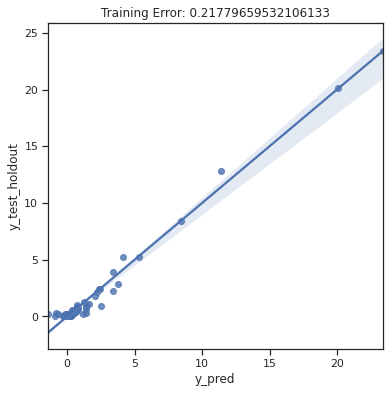

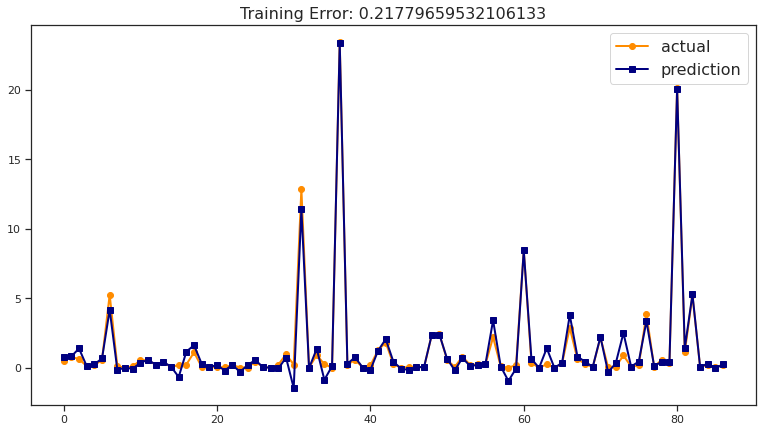

TEST ERROR: 412.622250
Predicted value: 
 
[  5.84940449   3.14635505   4.68754466  -0.32462914  -1.11863506
   3.70750195  -0.17160295   7.95927694   2.04673762   5.67726204
  20.33805853   3.5401612    6.12015976   4.44317053   3.46986268
   3.17644676  -5.18077236  -1.40414701   9.39030059 101.5047122
   6.24767603   7.28800616]
Actual value: 
 
[3.68     0.348067 2.09     0.245655 0.942803 0.220648 0.046815 3.84
 0.625696 1.95     0.443365 0.361564 1.08     2.2      0.371102 2.79
 0.062887 0.150417 3.2      9.77     0.396967 0.584651]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


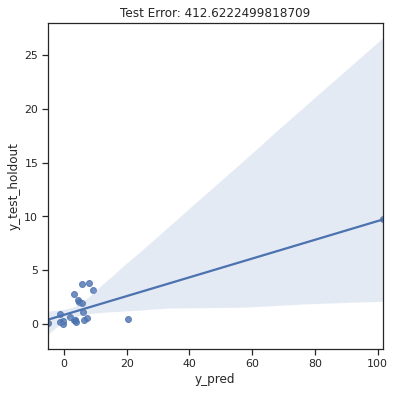

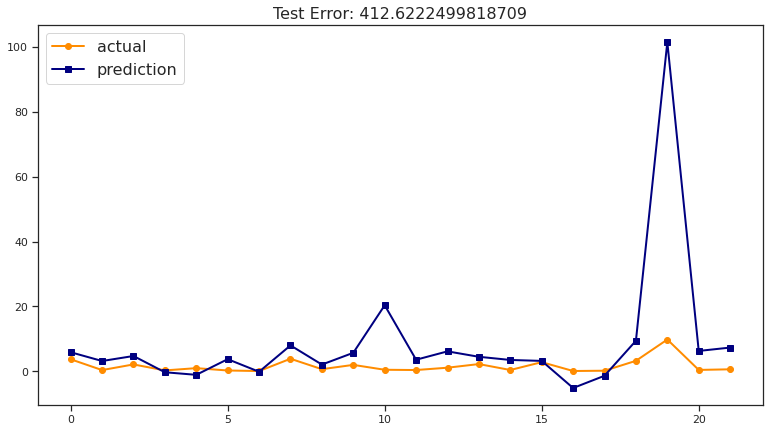

Predicted value ICO 0x (Actual value: 1.08) after 6 months:  [6.12015976]


In [ ]:
regressor, trainingError, y_pred_training = trainingError(X_cross, y_cross)  
test_error, y_pred_holdout = testError(X_test_holdout, y_test_holdout, regressor)
print("TRAINING ERROR: {:f}".format(trainingError))
heading = "Training Error: " + str(trainingError)
plotExpectedVsPredictedOutput2(y_cross, y_pred_training, fileName = heading, saveToFile = True)
line_plot(y_cross, y_pred_training, title= heading, lw=2)
print("TEST ERROR: {:f}".format(test_error))
heading = "Test Error: " + str(test_error)
print("Predicted value: \n ")
print(y_pred_holdout)
print("Actual value: \n ")
print(y_test_holdout)

plotExpectedVsPredictedOutput2(y_test_holdout, y_pred_holdout, fileName = heading, saveToFile = True)
line_plot(y_test_holdout, y_pred_holdout, title=heading, lw=2)

# ICO 0x CÓ GIÁ TRỊ DỰ ĐOÁN SAU 6 THÁNG LÀ 1.08
ico_0x= np.array([1.71456,0.00019931,1000000000,905793616,528295082,24000000,297.63,3420.4,19916186,10,8,9,182])
y_pred1 = makePrediction(regressor, ico_0x)
print("Predicted value ICO 0x (Actual value: 1.08) after 6 months: ", y_pred1)

## **HÀM TỐI ƯU KẾT QUẢ**

In [ ]:
"""
LƯU LẠI MODEL TỐT NHẤT.
"""
def saveBestModel(model,fileName):
    exists = os.path.isfile(fileName)    
    if exists:    
        joblib.load(fileName)
    else:
        joblib.dump(model, fileName)
        return    
    
    y_pred_holdout_saved_model = joblib.load(fileName).predict(X_test_holdout)
    rSquared_saved_model = r2_score(y_test_holdout, y_pred_holdout_saved_model)
    rMse_saved_model = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout_saved_model))
    mAE_saved_model = mean_absolute_error(y_test_holdout, y_pred_holdout_saved_model)
    
   
    y_pred_holdout_new_model = model.predict(X_test_holdout)
    rSquared_new_model = r2_score(y_test_holdout, y_pred_holdout_new_model)
    rMse_new_model = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout_new_model))
    mAE_new_model = mean_absolute_error(y_test_holdout, y_pred_holdout_new_model)
    
    #KIỂM TRA ĐIỀU KIỆN
    if(str(LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR.name) in fileName):
        if(rMse_new_model < rMse_saved_model):
            joblib.dump(model, fileName) 
    elif(str(LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR.name) in fileName):
        if(mAE_new_model < mAE_saved_model):
            joblib.dump(model, fileName) 
    else:
        if(rSquared_new_model > rSquared_saved_model and rSquared_new_model < 1):
            joblib.dump(model, fileName)  

In [ ]:
def Optimize(metricToOptimize, numIterations, x, y, showOutput = True):
     
    # GIÁ TRỊ R2, rMSE, MAE CỦA HỒI QUY RIDGE
    maxRSquared_Ridge = -10000
    rMSEMin_Ridge = 10000
    meanABError_min = 10000   

    crossValidationMeanSquaredError = 1
    crossValidationMeanAbsoluteError = 1
    crossValidationR2Squared = 1
    bestRidgeModel = None 

    plotrMSE = []
    plotR2 = []
    plotMAE = []  

    # HỆ SỐ HỒI QUY KHI SỬ DỤNG HỒI QUY RIDGE    
    bestRegressionCoef_temp_Ridge = np.array([])
    bestRegressionCoef_rMSE_Ridge = np.array([])
    bestRegressionCoef_R2_Ridge = np.array([])
    bestRegressionCoef_MAE_Ridge = np.array([])    

    for i in np.arange(numIterations):
        bestRegression_Ridge, rootMeanSquaredError_Ridge, rSquared_Ridge, meanAbsoluteError, bestRegressionCoef_temp_Ridge  = ridgeRegression(x, y)
              
#       TÌM GIÁ TRỊ rMSE TỐT NHẤT
        if(metricToOptimize == LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR):
            if(rootMeanSquaredError_Ridge < rMSEMin_Ridge):
                rMSEMin_Ridge = rootMeanSquaredError_Ridge              
                crossValidationMeanSquaredError = rootMeanSquaredError_Ridge
                plotrMSE.append(rootMeanSquaredError_Ridge)               
                bestRegressionCoef_rMSE_Ridge = bestRegressionCoef_temp_Ridge 
                bestRidgeModel = bestRegression_Ridge
            if(showOutput):
                print(i," bestrMSE: ", rMSEMin_Ridge)

        elif(metricToOptimize == LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR):
            if(meanAbsoluteError < meanABError_min):
                meanABError_min = meanAbsoluteError
                plotMAE.append(meanAbsoluteError)                             
                bestRegressionCoef_MAE_Ridge = bestRegressionCoef_temp_Ridge
                crossValidationMeanAbsoluteError = meanAbsoluteError
                bestRidgeModel = bestRegression_Ridge                   
            if(showOutput):
                print(i," bestrMAE: ", meanABError_min)                      
#      Tìm GIÁ TRỊ R2 TỐT NHẤT
        else:
            if(rSquared_Ridge > maxRSquared_Ridge and rSquared_Ridge > 0):
                maxRSquared_Ridge = rSquared_Ridge               
                bestRegressionCoef_R2_Ridge = bestRegressionCoef_temp_Ridge
                plotR2.append(rSquared_Ridge)  
                crossValidationR2Squared = rSquared_Ridge
                bestRidgeModel = bestRegression_Ridge                  
            if(showOutput):
                print(i,"bestRSquared:",maxRSquared_Ridge)   
   
   
          
    if(metricToOptimize == LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR):
        print(" \n Best rMSE: {:f} \n ,after running linear regression {:d} different times with different test and training combinations"
              .format(rMSEMin_Ridge,numIterations))
        print("Value alpha: ", bestRidgeModel.alpha_)     
        line_plot2(plotrMSE, title='Optimize value rMSE on validation data', 
                   label1='rMSE')      
        
    elif(metricToOptimize == LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR):
        print(" \n Best MAE: {:f} \n ,after running linear regression {:d} different times with different test and training combinations"
              .format(meanABError_min,numIterations))
        print("Value alpha: ", bestRidgeModel.alpha_)    
        line_plot2(plotMAE, title='Optimize value MAE on validation data',
                    label1='MAE')    
    else: 
       print(" \n Best RSquared: {:f} \n ,after running linear regression {:d} different times with different test and training combinations"
              .format(maxRSquared_Ridge,numIterations))
       print("Value alpha: ", bestRidgeModel.alpha_)    
       line_plot2(plotR2, title='Optimize value R2 on validation data', 
                   label1='R2')   
     
    if(showOutput):
        print(" \n Best regression coef rMSE: ", bestRegressionCoef_rMSE_RG,"\n")
        print(" \n Best regression coef R2: ", bestRegressionCoef_R2_RG,"\n")
        print(" \n Best regression coef MAE: ", bestRegressionCoef_MAE_Ridge,"\n")
    
    fileName_Ridge = "RESULT/" + "bestRegressionModel_Ridge_" + str(metricToOptimize.name) + ".sav"   
    saveBestModel(bestRidgeModel, fileName_Ridge)   

In [ ]:
ico_0x = np.array([1.71456,0.00019931,1000000000,905793616,528295082,24000000,297.63,3420.4,19916186,10,8,9,182])
ico_modum = np.array([2.36319,0.00027471,27266200,43166501,18266200,13500000,383.47,4701.76,193336,15,9,1,33])
ico_crypto20 = np.array([1.68825,0.00019625,40656082,66992446,39681591,38222081,308.89,4369.35,6095383,14,10,7,196])
def Optimize2(numIterations, x, y):
    for i in np.arange(numIterations):
        bestRegression_Ridge, rootMeanSquaredError_Ridge, rSquared_Ridge, meanAbsoluteError, bestRegressionCoef_temp_Ridge  = ridgeRegression(x, y)
        y_pred_ico0x = makePrediction(bestRegression_Ridge, ico_0x)
        y_pred_modum = makePrediction(bestRegression_Ridge, ico_modum)
        y_pred_crypto20 = makePrediction(bestRegression_Ridge, ico_crypto20)
        y_pred_holdout = bestRegression_Ridge.predict(X_test_holdout) 
        rMSE_holdout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout))
        r2_holdout = r2_score(y_test_holdout, y_pred_holdout)
        holdout_MAE = mean_absolute_error(y_test_holdout, y_pred_holdout)
        print("TIME: ",i)
        print("Price ICO 0x (REAL: 1.08): ", y_pred_ico0x)
        print("Price ICO modum (REAL: 2.79): ", y_pred_modum)
        print("Price ICO crypto20 (REAL: 0.9876): ", y_pred_crypto20)
        print("Value rMSE: ", rMSE_holdout)
        print("Value R2: ", r2_holdout)
        print("Value MAE: ", holdout_MAE)
        print("**********************************************************************************")
        print("\n")

## **SO SÁNH CÁC THAM SỐ GIỮA HỒI QUY RIDGE VÀ HÔI QUY ĐA BIẾN**
Sau khi chạy tổ hợp 10000 lần khác nhau với tập huấn luyện

 
 Best rMSE: 0.385593 
 ,after running linear regression 20000 different times with different test and training combinations
Value alpha:  0.6


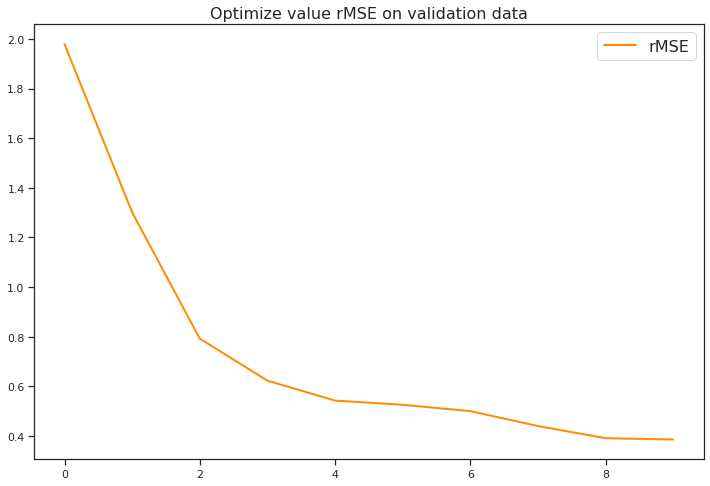

In [ ]:
n = 20000 # sô lần lặp
showOutput = False
saveToFile = False
Optimize(LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR, n , X_cross, y_cross, showOutput)

 
 Best RSquared: 0.924796 
 ,after running linear regression 20000 different times with different test and training combinations
Value alpha:  1.1


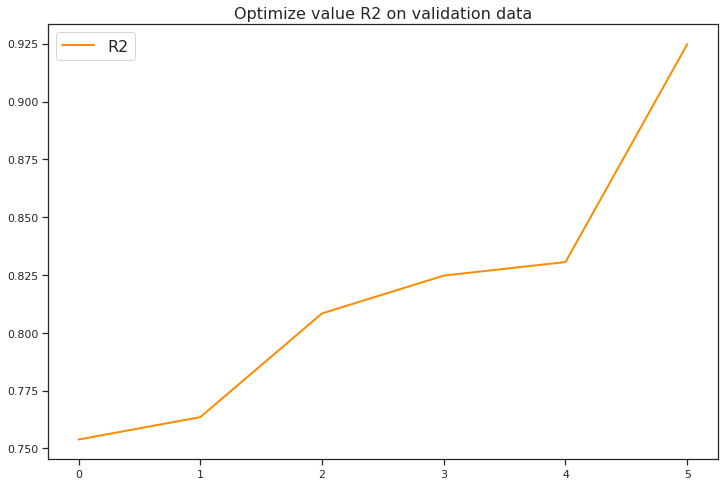

In [ ]:
n = 20000 # sô lần lặp
Optimize(LineaReggressionMetrics.R_SQUARED, n, X_cross, y_cross, showOutput)
#  https://stats.stackexchange.com/questions/12900/when-is-r-squared-negative

 
 Best MAE: 0.258573 
 ,after running linear regression 20000 different times with different test and training combinations
Value alpha:  0.6


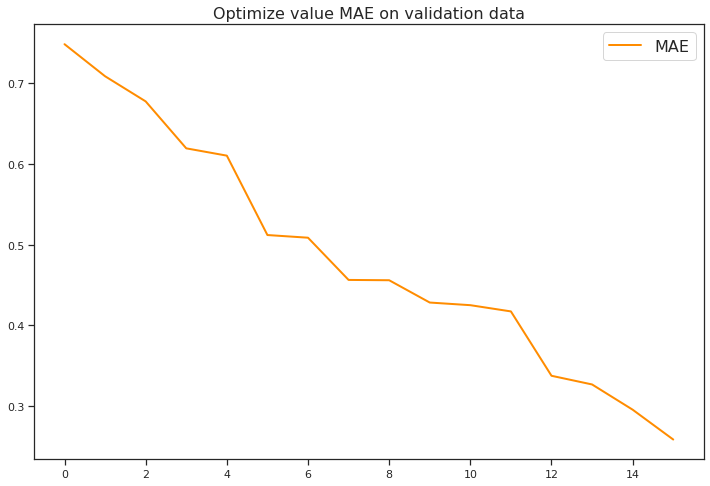

In [ ]:
n = 20000 # sô lần lặp
Optimize(LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR, n, X_cross, y_cross, showOutput)

So sánh 2 cách tiếp cận: 
- Tìm ra model tối ưu từng thông số rMSE, R2, MAE
- Đi lấy model hình khi huấn luyện đi dự đoán rồi xem giá trị nào gần thực tế nhất thì chọn rồi suy ngược lại 3 giá trị tối ưu

In [ ]:
 Optimize2(100, X_cross, y_cross)

TIME:  0
Price ICO 0x (REAL: 1.08):  [2.12064133]
Price ICO modum (REAL: 2.79):  [2.41603506]
Price ICO crypto20 (REAL: 0.9876):  [1.04144177]
Value rMSE:  3.2051621608427947
Value R2:  -1.2270717349538316
Value MAE:  1.4554333165134026
**********************************************************************************


TIME:  1
Price ICO 0x (REAL: 1.08):  [2.27946332]
Price ICO modum (REAL: 2.79):  [2.85262804]
Price ICO crypto20 (REAL: 0.9876):  [2.01142654]
Value rMSE:  3.964493339967903
Value R2:  -2.407293755946178
Value MAE:  1.4588351641165687
**********************************************************************************


TIME:  2
Price ICO 0x (REAL: 1.08):  [2.30132564]
Price ICO modum (REAL: 2.79):  [2.57662148]
Price ICO crypto20 (REAL: 0.9876):  [1.18221123]
Value rMSE:  3.9076936494953753
Value R2:  -2.3103598835518633
Value MAE:  1.6393868699427125
**********************************************************************************


TIME:  3
Price ICO 0x (REAL: 1.08): 

### **LOAD MODEL ĐÃ LƯU VÀ VẼ BIỂU ĐỒ** 

Predicted value when using best model rMSE: 
[ 2.76162561  0.59052417  2.43436351  0.40393373  0.56452347 -0.53468191
  0.03388609  3.87064975  1.28719003  1.26801252  4.69980691  2.49155839
  1.62898733  1.98241914  0.90508728  2.44069169 -1.23358276  0.12569275
  4.97234346 17.80754642  0.90202488  1.11556728]
Actual value: 
[3.68     0.348067 2.09     0.245655 0.942803 0.220648 0.046815 3.84
 0.625696 1.95     0.443365 0.361564 1.08     2.2      0.371102 2.79
 0.062887 0.150417 3.2      9.77     0.396967 0.584651]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


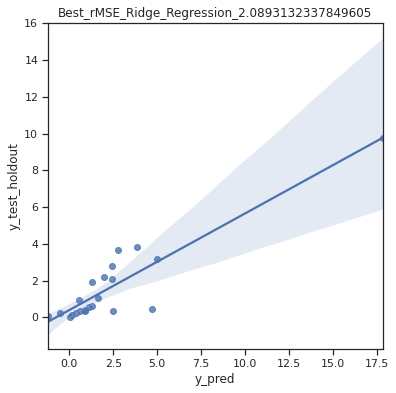

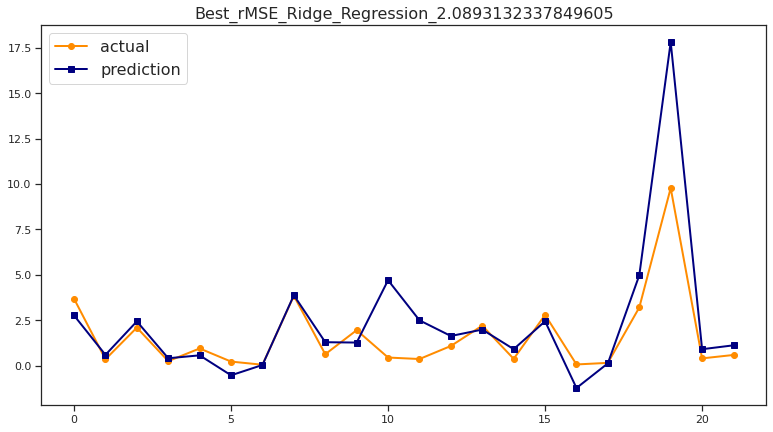

Regression coefficient when using best model rMSE: 
[ 3.41521891e-01  2.93791959e+03 -3.52631303e-14 -5.72452206e-10
 -1.10065729e-12  4.22505971e-09 -2.57478520e-03 -1.49110187e-04
  1.95862788e-11 -1.61877760e-03 -1.07012357e+00 -8.57027777e-01
  8.99895738e-02  1.29429448e+00 -2.71036073e-01 -1.04067852e-01
 -2.52289169e-01 -3.24752356e-01  1.69370589e+00  7.50895359e-01
  0.00000000e+00  0.00000000e+00  1.75117606e-01 -2.05786562e-01
 -1.45823776e-01 -5.18395708e-03 -4.32912409e-01  1.07423737e-01
 -2.20815941e-01 -1.16703644e-01 -3.00944343e-01 -2.87953177e-01
  6.16422812e-01 -6.67762923e-01 -6.91690272e-02 -8.57027777e-01
 -3.08741199e-01  3.49243952e-02 -8.72917291e-02 -1.12928702e-01
 -9.65083143e-01  5.25037215e-01 -3.41260655e-01 -2.61484546e-01
 -1.62249008e+00 -1.66742282e-01  3.65223145e-02  0.00000000e+00
  0.00000000e+00 -3.87399654e-01 -3.05681817e-01  4.28339671e+00
  8.12949393e-02  1.45936712e-01 -4.00546952e-01  4.58737704e-01
 -1.16229233e-01 -4.87384061e-01  1.85

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


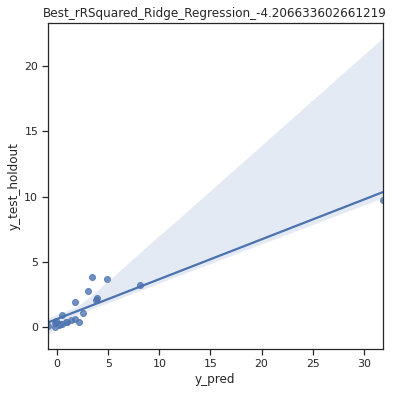

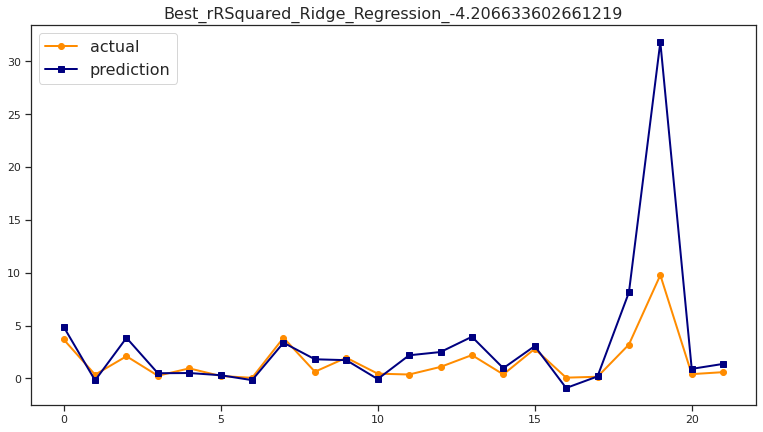

Regression coefficient when using best model R2: 
[ 5.78059930e-01  4.97223450e+03 -3.10286132e-14 -1.05921060e-10
 -6.32650420e-13  4.53692880e-09 -1.05395770e-04 -6.38523250e-05
  2.33556909e-13 -4.13202726e-03  0.00000000e+00  0.00000000e+00
  1.37599339e-01  1.02007788e+00 -8.44629359e-02 -2.06873683e-01
 -1.66836559e-01 -1.21996310e-01  1.02679945e-01  4.87628602e-01
  1.07552341e-01 -3.38872732e-02  7.94121684e-02 -3.36187454e-02
 -6.98399551e-03 -3.10797004e-01 -5.10487002e-01  2.89152421e-02
 -9.49183075e-02 -9.59019351e-02 -9.06195701e-02  3.32189566e-03
  9.44964436e-02 -1.94025335e-01 -4.80551758e-02  0.00000000e+00
 -2.27989368e-02 -8.72592417e-02 -1.09315898e-01 -4.79790618e-02
 -4.40059147e-01  3.45355109e-01 -9.13787228e-03  1.03285241e-02
 -7.54376045e-01  7.41291715e-02  0.00000000e+00 -1.90055097e-02
  1.57616479e-02 -1.03475773e-01  3.61952588e-02  0.00000000e+00
  1.15397247e-01  5.83729732e-01 -2.07135453e-01  0.00000000e+00
 -4.22843282e-02 -1.11376498e-01  0.0000

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


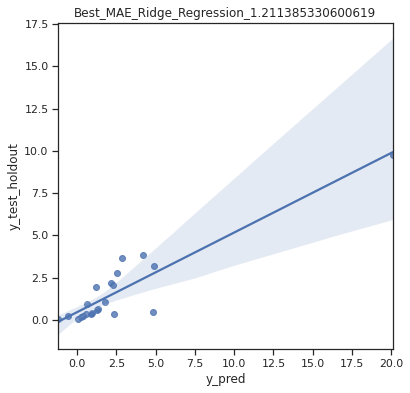

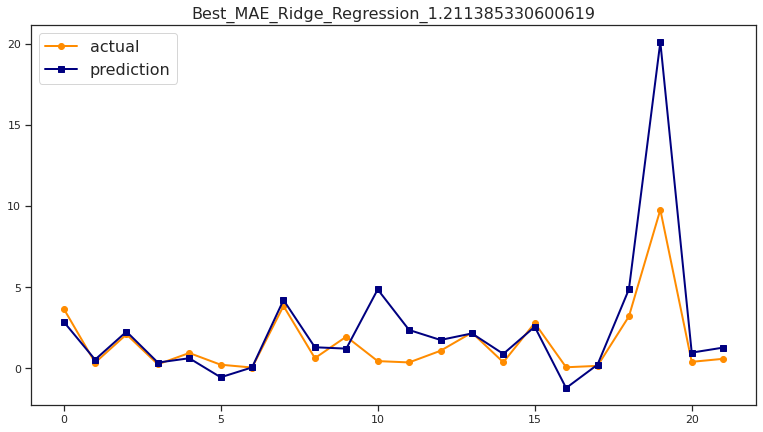

Regression coefficient when using best model MAE: 
[ 5.78059930e-01  4.97223450e+03 -3.10286132e-14 -1.05921060e-10
 -6.32650420e-13  4.53692880e-09 -1.05395770e-04 -6.38523250e-05
  2.33556909e-13 -4.13202726e-03  0.00000000e+00  0.00000000e+00
  1.37599339e-01  1.02007788e+00 -8.44629359e-02 -2.06873683e-01
 -1.66836559e-01 -1.21996310e-01  1.02679945e-01  4.87628602e-01
  1.07552341e-01 -3.38872732e-02  7.94121684e-02 -3.36187454e-02
 -6.98399551e-03 -3.10797004e-01 -5.10487002e-01  2.89152421e-02
 -9.49183075e-02 -9.59019351e-02 -9.06195701e-02  3.32189566e-03
  9.44964436e-02 -1.94025335e-01 -4.80551758e-02  0.00000000e+00
 -2.27989368e-02 -8.72592417e-02 -1.09315898e-01 -4.79790618e-02
 -4.40059147e-01  3.45355109e-01 -9.13787228e-03  1.03285241e-02
 -7.54376045e-01  7.41291715e-02  0.00000000e+00 -1.90055097e-02
  1.57616479e-02 -1.03475773e-01  3.61952588e-02  0.00000000e+00
  1.15397247e-01  5.83729732e-01 -2.07135453e-01  0.00000000e+00
 -4.22843282e-02 -1.11376498e-01  0.000

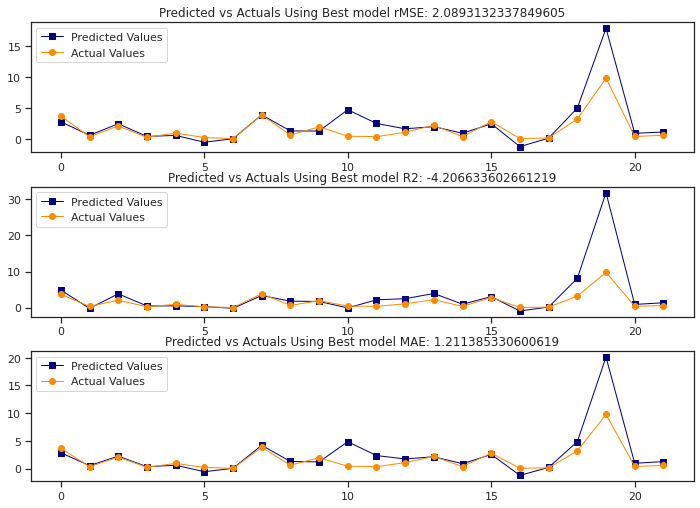

In [ ]:
# LOAD MODEL SỬ DỤNG HỒI QUY RIDGE - rMSE
fileName1 = "RESULT/" + "bestRegressionModel_Ridge_" + str(LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR.name) + ".sav"
bestRegression_rMSE_Ridge = loadModel(fileName1)
saveToFile = True
y_pred_holdout_rMSE = []
y_pred_holdout_R2 = []
y_pred_holdout_MAE = []

holdOutMeanSquaredError = 0.0
holdOutValidationR2Squared = 0.0
holdOutMeanABError = 0.0

if(bestRegression_rMSE_Ridge):
    y_pred_holdout_rMSE = bestRegression_rMSE_Ridge.predict(X_test_holdout)  
    holdOutMeanSquaredError = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout_rMSE))
    print("Predicted value when using best model rMSE: ")
    print(y_pred_holdout_rMSE)   
    print("Actual value: ")
    print(y_test_holdout)
    heading = "Best_rMSE_Ridge_Regression_" + str(holdOutMeanSquaredError)
    plotExpectedVsPredictedOutput2(y_test_holdout, y_pred_holdout_rMSE, heading, saveToFile)
    #plotExpectedVsPredictedOutput(y_test_holdout, y_pred_holdout_rMSE, heading, saveToFile)
    line_plot(y_test_holdout, y_pred_holdout_rMSE, title=heading, lw=2)
    print("Regression coefficient when using best model rMSE: ")  
    print(bestRegression_rMSE_Ridge.coef_)
    print("************************************************************************************************")
    print("\n")

# LOAD MODEL SỬ DỤNG HỒI QUY RIDGE - R2
fileName3 = "RESULT/" + "bestRegressionModel_Ridge_" + str(LineaReggressionMetrics.R_SQUARED.name) + ".sav"
bestRegression_rSquared_Ridge = loadModel(fileName3)

if(bestRegression_rSquared_Ridge):
    y_pred_holdout_R2 = bestRegression_rSquared_Ridge.predict(X_test_holdout)   
    holdOutValidationR2Squared = r2_score(y_test_holdout, y_pred_holdout_R2)
    print("Predicted value when using best model R2: ")
    print(y_pred_holdout_R2)
    print("Actual value: ")
    print(y_test_holdout)
    heading = "Best_rRSquared_Ridge_Regression_" + str(holdOutValidationR2Squared)
    plotExpectedVsPredictedOutput2(y_test_holdout, y_pred_holdout_R2,heading, saveToFile)
    #plotExpectedVsPredictedOutput(y_test_holdout, y_pred_holdout_R2,heading, saveToFile)
    line_plot(y_test_holdout, y_pred_holdout_R2, title=heading, lw=2)
    print("Regression coefficient when using best model R2: ")
    print(bestRegression_rSquared_Ridge.coef_) 
    print("************************************************************************************************")
    print("\n")

fileName4 = "RESULT/" + "bestRegressionModel_Ridge_" + str(LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR.name) + ".sav"
bestRegression_MAE_Ridge = loadModel(fileName4)

if(bestRegression_MAE_Ridge):
    y_pred_holdout_MAE = bestRegression_MAE_Ridge.predict(X_test_holdout)   
    holdOutMeanABError = mean_absolute_error(y_test_holdout, y_pred_holdout_MAE)
    print("Predicted value when using best model MAE: ")
    print(y_pred_holdout_MAE)
    print("Actual value: ")
    print(y_test_holdout)
    heading = "Best_MAE_Ridge_Regression_" + str(holdOutMeanABError)
    plotExpectedVsPredictedOutput2(y_test_holdout,y_pred_holdout_MAE,heading,saveToFile)
    #plotExpectedVsPredictedOutput(y_test_holdout,y_pred_holdout_MAE,heading,saveToFile)
    line_plot(y_test_holdout, y_pred_holdout_MAE, title=heading, lw=2)    
    print("Regression coefficient when using best model MAE: ")
    print(bestRegression_rSquared_Ridge.coef_)

plotResult(y_test_holdout, y_pred_holdout_rMSE, y_pred_holdout_R2, y_pred_holdout_MAE, rMSE = str(holdOutMeanSquaredError), 
           R2 = str(holdOutValidationR2Squared), MAE = str(holdOutMeanABError))

## **SỬ DỤNG MODEL ĐỂ DỰ ĐOÁN - GIÁ TRỊ CỦA ICO SAU 6 THÁNG**

Price of 3 ICO when using best mode rMSE
Predicted value of ICO 0x (real price: 1.08) after 6 months:  [1.62898733]
Predicted value of ICO modum (real price: 2.79) after 6 months:  [2.44069169]
Predicted value of ICO crypto20 (real price: 0.9786) after 6 months:  [1.28755553]
Value rMSE, R2, MAE of best model rMSE
Value rMSE:  2.0893132337849605
Value R2:  0.05367284505498282
Value MAE:  1.1085227062608147
*******************************************************************************************


Price of 3 ICO when using best mode R2
Predicted value of ICO 0x (real price: 1.08) after 6 months:  [2.48923405]
Predicted value of ICO modum (real price: 2.79) after 6 months:  [3.05210583]
Predicted value of ICO crypto20 (real price: 0.9786) after 6 months:  [1.36034043]
Value rMSE, R2, MAE of best model R2
Value rMSE:  4.9007371784621645
Value R2:  -4.206633602661219
Value MAE:  1.9060384345358885
*******************************************************************************************

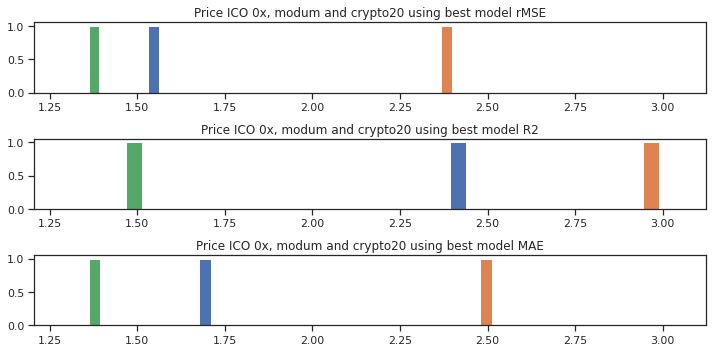

In [ ]:
# LOAD MODEL VỚI GIÁ TRỊ rMSE LÀ TỐT NHẤT
fileName1 = "RESULT/" + "bestRegressionModel_Ridge_" + str(LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR.name) + ".sav"
bestRegression_rMSE_Ridge = joblib.load(fileName1)
price_rMSE = []
price_R2 = []
price_MAE = []
#price_usd,price_btc,total_supply,market_cap_usd,available_supply,usd_raised,eth_price_launch,btc_price_launch,ico_duration,month,day,country
ico_0x = np.array([1.71456,0.00019931,1000000000,905793616,528295082,24000000,297.63,3420.4,19916186,10,8,9,182])
ico_modum = np.array([2.36319,0.00027471,27266200,43166501,18266200,13500000,383.47,4701.76,193336,15,9,1,33])
ico_crypto20 = np.array([1.68825,0.00019625,40656082,66992446,39681591,38222081,308.89,4369.35,6095383,14,10,7,196])
ico_wanchin = np.array([6.71639,0.00078075,210000000,712961540,106152493,35704520,297.48,4408.46,214184771,11,10,3,182])
y_pred1 = makePrediction(bestRegression_rMSE_Ridge, ico_0x)
y_pred2 = makePrediction(bestRegression_rMSE_Ridge, ico_modum)
y_pred3 = makePrediction(bestRegression_rMSE_Ridge, ico_crypto20)
price_rMSE.append(y_pred1)
price_rMSE.append(y_pred2)
price_rMSE.append(y_pred3)
y_pred_holdout_rMSE = bestRegression_rMSE_Ridge.predict(X_test_holdout) 
rMSE_holdout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout_rMSE))
r2_holdout = r2_score(y_test_holdout, y_pred_holdout_rMSE)
holdout_MAE  = mean_absolute_error(y_test_holdout, y_pred_holdout_rMSE)
print("Price of 3 ICO when using best mode rMSE")
print("Predicted value of ICO 0x (real price: 1.08) after 6 months: ",y_pred1)
print("Predicted value of ICO modum (real price: 2.79) after 6 months: ",y_pred2)
print("Predicted value of ICO crypto20 (real price: 0.9786) after 6 months: ",y_pred3)
print("Value rMSE, R2, MAE of best model rMSE")
print("Value rMSE: ", rMSE_holdout)
print("Value R2: ", r2_holdout)
print("Value MAE: ", holdout_MAE)
print("*******************************************************************************************")
print("\n")

# LOAD MODEL VỚI GIÁ TRỊ R2 LÀ TỐT NHẤT
fileName2 = "RESULT/" + "bestRegressionModel_Ridge_" + str(LineaReggressionMetrics.R_SQUARED.name) + ".sav"
bestRegression_rSquared_Ridge = joblib.load(fileName2)
y_pred4 = makePrediction(bestRegression_rSquared_Ridge, ico_0x)
y_pred5 = makePrediction(bestRegression_rSquared_Ridge, ico_modum)
y_pred6 = makePrediction(bestRegression_rSquared_Ridge, ico_crypto20)
price_R2.append(y_pred4)
price_R2.append(y_pred5)
price_R2.append(y_pred6)
y_pred_holdout_R2 = bestRegression_rSquared_Ridge.predict(X_test_holdout) 
rMSE_holdout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout_R2))
r2_holdout = r2_score(y_test_holdout, y_pred_holdout_R2)
holdout_MAE  = mean_absolute_error(y_test_holdout, y_pred_holdout_R2)
print("Price of 3 ICO when using best mode R2")
print("Predicted value of ICO 0x (real price: 1.08) after 6 months: ",y_pred4)
print("Predicted value of ICO modum (real price: 2.79) after 6 months: ",y_pred5)
print("Predicted value of ICO crypto20 (real price: 0.9786) after 6 months: ",y_pred6)
print("Value rMSE, R2, MAE of best model R2")
print("Value rMSE: ", rMSE_holdout)
print("Value R2: ", r2_holdout)
print("Value MAE: ", holdout_MAE)
print("*******************************************************************************************")
print("\n")

# LOAD MODEL VỚI GIÁ TRỊ MAE LÀ TỐT NHẤT
fileName3 = "RESULT/" + "bestRegressionModel_Ridge_" + str(LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR.name) + ".sav"
bestRegression_MAE_Ridge = joblib.load(fileName3)
y_pred7 = makePrediction(bestRegression_MAE_Ridge, ico_0x)
y_pred8 = makePrediction(bestRegression_MAE_Ridge, ico_modum)
y_pred9 = makePrediction(bestRegression_MAE_Ridge, ico_crypto20)
price_MAE.append(y_pred7)
price_MAE.append(y_pred8)
price_MAE.append(y_pred9)
y_pred_holdout_MAE = bestRegression_MAE_Ridge.predict(X_test_holdout) 
rMSE_holdout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout_MAE))
r2_holdout = r2_score(y_test_holdout, y_pred_holdout_MAE)
holdout_MAE  = mean_absolute_error(y_test_holdout, y_pred_holdout_MAE)
print("Price of 3 ICO when using best mode MAE")
print("Predicted value of ICO 0x (real price: 1.08) after 6 months: ",y_pred7)
print("Predicted value of ICO modum (real price: 2.79) after 6 months: ",y_pred8)
print("Predicted value of ICO crypto20 (real price: 0.9786) after 6 months: ",y_pred9)
print("Value rMSE, R2, MAE of best model MAE")
print("Value rMSE: ", rMSE_holdout)
print("Value R2: ", r2_holdout)
print("Value MAE: ", holdout_MAE)
print("*******************************************************************************************")
print("\n")
plotPredicted(price_rMSE, price_R2, price_MAE)

# **Neural Network**

Các hàm dùng để chạy NN với nhiều cấu hình khác nhau.

In [ ]:
class Activations(Enum):
    identity = 1
    logistic = 2
    tanh    = 3
    relu = 4


In [ ]:
## LƯU MODEL NẾU MODEL TỐT HƠN MODEL ĐÃ LƯU TRƯỚC ĐÓ
def saveBestModelNN(model, fileName):
    exists = os.path.isfile(fileName)
    if exists:    
        # LOAD MODEL ĐÃ LƯU
        bestSavedNNModel = joblib.load(fileName)
    else:
        # LƯU MODEL HIỆN TẠI
        joblib.dump(model, fileName)
        return
    y_pred_holdout_saved_model = bestSavedNNModel.predict(X_test_holdout)
    rSquared_saved_model = r2_score(y_test_holdout, y_pred_holdout_saved_model)
    rMse_saved_model = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout_saved_model))
    mAE_saved_model = mean_absolute_error(y_test_holdout, y_pred_holdout_saved_model)
    
    #Scores CHO MODEL MỚI
    y_pred_holdout_new_model = model.predict(X_test_holdout)
    rSquared_new_model = r2_score(y_test_holdout, y_pred_holdout_new_model)
    rMse_new_model = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout_new_model))
    mAE_new_model = mean_absolute_error(y_test_holdout, y_pred_holdout_new_model)  
    
    if(str(LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR.name) in fileName):
        if(rMse_new_model < rMse_saved_model):
            joblib.dump(model, fileName) 
    elif(str(LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR.name) in fileName):
        if(mAE_new_model < mAE_saved_model):
           joblib.dump(model, fileName)  
    else:
        if(rSquared_new_model > rSquared_saved_model and rSquared_new_model > 0):
            joblib.dump(model, fileName)   


In [ ]:
# HÀM runNN DÙNG ĐỂ TÍNH TOÁN VÀ TRẢ VỀ CÁC GIÁ TRỊ R2, rMSE, model, y_val là validation
def runNN(x_input, y_input, hidden_layer_size, chosen_solver, chosen_activation):
    X_train, X_val, y_train, y_val = train_test_split(x_input, y_input, test_size = 0.2, random_state = 0)

    mlp = MLPRegressor(hidden_layer_sizes=(hidden_layer_size, hidden_layer_size, hidden_layer_size), max_iter= 60000, 
                       activation=chosen_activation, solver=chosen_solver, learning_rate='adaptive', tol=0.001)
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_val)  

    R2coefficient = r2_score(y_val, y_pred)
    rMeanSquaredError = sqrt(mean_squared_error(y_val, y_pred))
    meanAbsoluteError = mean_squared_error(y_val, y_pred)
    
    return R2coefficient, rMeanSquaredError, meanAbsoluteError, mlp

In [ ]:
def runNeuralNetOptimizer(metricToOptimize, x_input, y_input, maxIterations, maxHiddenLayerSize, activation, solver, hiddenLayerStepSize=100, showOutput=False):
    bestNeuralNetworkModel = None 
    minrMSE = 10000
    maxR2coefficient = -10000
    minMAE = 10000
    plotrMSE = []
    plotR2 = []
    plotMAE = []
 
    
    # CHẠY NN VỚI NHIỀU KÍCH THƯỚC LỚP ẨN KHÁC NHAU  
    for i in np.arange(maxIterations):
             for hidden_layer_size in np.arange(1, maxHiddenLayerSize, hiddenLayerStepSize):               
                chosen_activation = activation
                chosen_solver = solver
                currentR2coefficient, currentrMSE, currentMAE, neuralNetworkModel = runNN(x_input, y_input, hidden_layer_size, chosen_solver, chosen_activation)
               
                if(metricToOptimize == LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR):
                    if(minrMSE > currentrMSE ):
                        minrMSE = currentrMSE
                        minMAE = currentMAE
                        maxR2coefficient = currentR2coefficient
                        plotrMSE.append(currentrMSE)                        
                        bestNeuralNetworkModel = neuralNetworkModel                        
                        
                elif(metricToOptimize == LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR):
                    if(minMAE > currentMAE):
                         minrMSE = currentrMSE
                         minMAE = currentMAE
                         maxR2coefficient = currentR2coefficient 
                         bestNeuralNetworkModel = neuralNetworkModel
                         plotMAE.append(currentMAE)                                          
                else:
                    if(maxR2coefficient < currentR2coefficient and currentR2coefficient > 0):
                         minrMSE = currentrMSE
                         minMAE = currentMAE
                         maxR2coefficient = currentR2coefficient 
                         bestNeuralNetworkModel = neuralNetworkModel
                         plotR2.append(currentR2coefficient)               
                                                  
                        
    if(bestNeuralNetworkModel):
        print("Best rMSE for NN, using validation data: " + str(minrMSE))
        print("Best rSquared for NN, using validation data: " + str(maxR2coefficient))
        print("Best MAE for NN, using validation data: " + str(minMAE))

        #Best values for NN using cross validation
        y_pred_holdout = bestNeuralNetworkModel.predict(X_test_holdout)       
        if(metricToOptimize == LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR):
            rMeanSquaredErrorHoldout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout))
            print("Best rMSE for NN, using holdout data: " + str(rMeanSquaredErrorHoldout))
            line_plot2(plotrMSE, title='Optimize value rMSE validation data when using solver ' + solver, 
                   label1='rMSE') 
        elif(metricToOptimize == LineaReggressionMetrics.R_SQUARED):
            R2coefficientHoldout = r2_score(y_test_holdout, y_pred_holdout)
            print("Best rSquared for NN, using holdout data: " + str(R2coefficientHoldout))
            line_plot2(plotR2, title='Optimize value R2 validation data when using solver ' + solver, 
                   label1='R2') 
        else:
            meanAbsoluteErrorHoldout= mean_absolute_error(y_test_holdout, y_pred_holdout)
            print("Best MAE for NN, using holdout data: " + str(meanAbsoluteErrorHoldout))
            line_plot2(plotMAE, title='Optimize value MAE validation data when using solver ' + solver, 
                   label1='MAE')   
        
        #Save best model
        fileName = "RESULT/" + "bestNNModel_" + str(metricToOptimize.name) + solver + ".sav"
        saveBestModelNN(bestNeuralNetworkModel,  fileName)

In [ ]:
def runNeuralNetOptimizations2(x_input, y_input, maxIterations, maxHiddenLayerSize, activation, solver, metricToOptimize, hiddenLayerStepSize=100,showOutput=False):
    runNeuralNetOptimizer(metricToOptimize, x_input, y_input, maxIterations, maxHiddenLayerSize, activation, solver, hiddenLayerStepSize,showOutput)

In [ ]:
maxIterations = 5
maxHiddenLayerSize = 1000
hiddenLayerStepSize = 100

In [ ]:
def findBestParametersNN(metricToOptimize):
    y_preds = np.array([])
    rMse = np.array([])
    y_actual = np.array([])
    
    # Using tanh activation function, with Adam Solver
    print("Using tanh activation function, with Adam Solver")
    runNeuralNetOptimizations2(X_cross, y_cross, maxIterations, maxHiddenLayerSize,
                               Activations.tanh.name, Solvers.adam.name, metricToOptimize, hiddenLayerStepSize)
    print("\n")
    
    # Using tanh activation function, with Gradient Descent Solver
    print("Using tanh activation function, with Gradient Descent Solver")
    runNeuralNetOptimizations2(X_cross,y_cross, maxIterations, maxHiddenLayerSize,
                               Activations.tanh.name, Solvers.sgd.name, metricToOptimize, hiddenLayerStepSize)
    print("\n")


## TÌM RA CÁC GIÁ TRỊ rMSE TỐT NHẤT

Using tanh activation function, with Adam Solver
Best rMSE for NN, using validation data: 0.9730485009073994
Best rSquared for NN, using validation data: 0.1821315451025186
Best MAE for NN, using validation data: 0.9468233851181372
Best rMSE for NN, using holdout data: 4.366271076146069


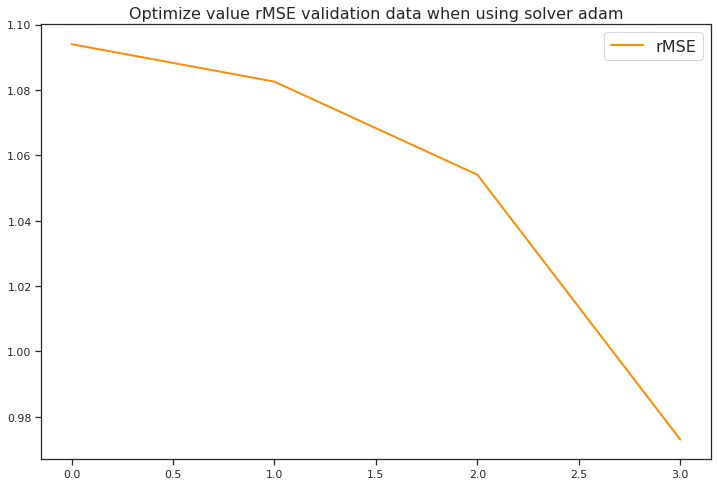



Using tanh activation function, with Gradient Descent Solver
Best rMSE for NN, using validation data: 1.0803539183786954
Best rSquared for NN, using validation data: -0.00819974874359053
Best MAE for NN, using validation data: 1.1671645889562008
Best rMSE for NN, using holdout data: 3.0717950833761205


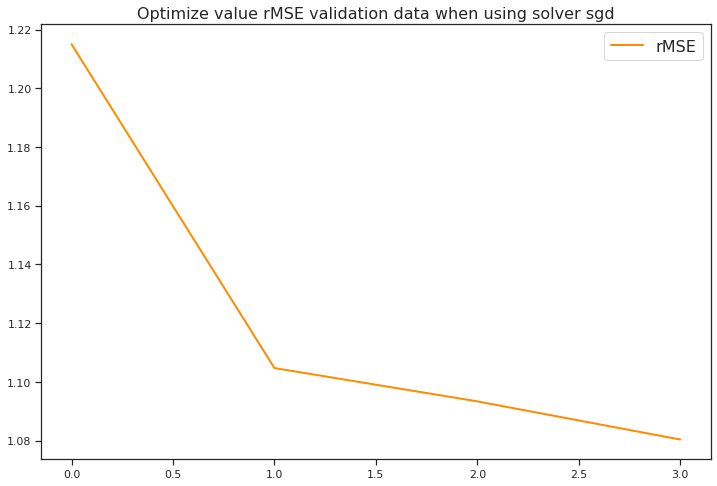

In [ ]:
findBestParametersNN(LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR)

##TÌM RA GIÁ TRỊ R2 TỐT NHẤT

Using tanh activation function, with Adam Solver
Best rMSE for NN, using validation data: 0.8330711019760556
Best rSquared for NN, using validation data: 0.4005145851972003
Best MAE for NN, using validation data: 0.6940074609475997
Best rSquared for NN, using holdout data: -2.7413278029407713


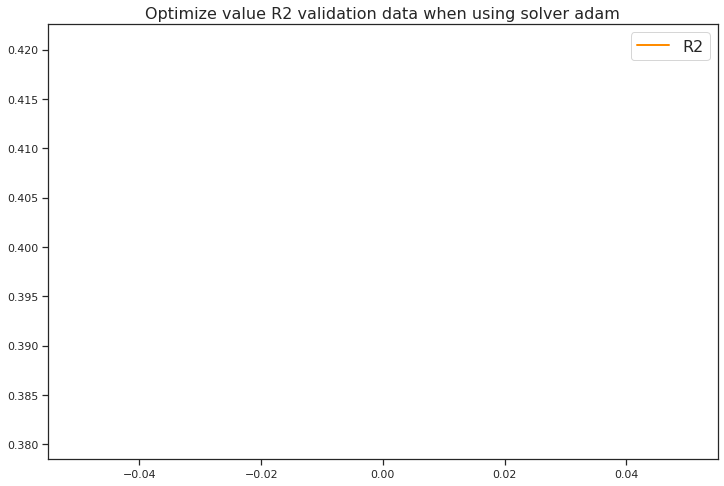



Using tanh activation function, with Gradient Descent Solver
Best rMSE for NN, using validation data: 1.002378222996982
Best rSquared for NN, using validation data: 0.13208393374280158
Best MAE for NN, using validation data: 1.0047621019385875
Best rSquared for NN, using holdout data: 0.11581977450796477


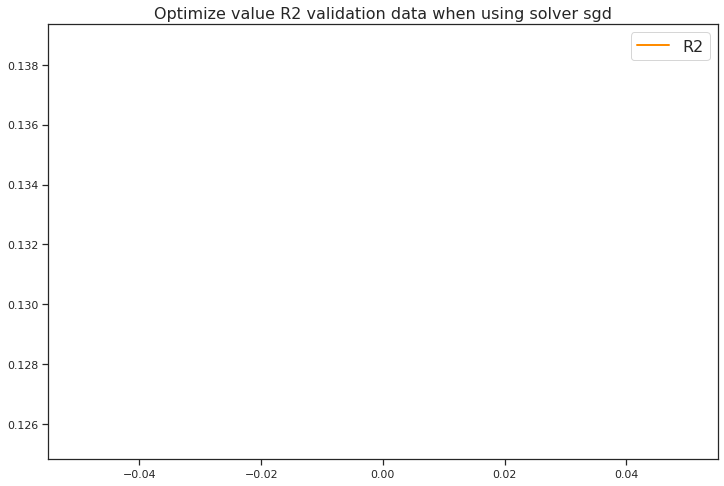

In [ ]:
findBestParametersNN(LineaReggressionMetrics.R_SQUARED)

##TÌM RA GIÁ TRỊ MAE TỐT NHẤT

Using tanh activation function, with Adam Solver
Best rMSE for NN, using validation data: 0.8946496387997326
Best rSquared for NN, using validation data: 0.3086141867738508
Best MAE for NN, using validation data: 0.8003979762044919
Best MAE for NN, using holdout data: 1.9814255091680435


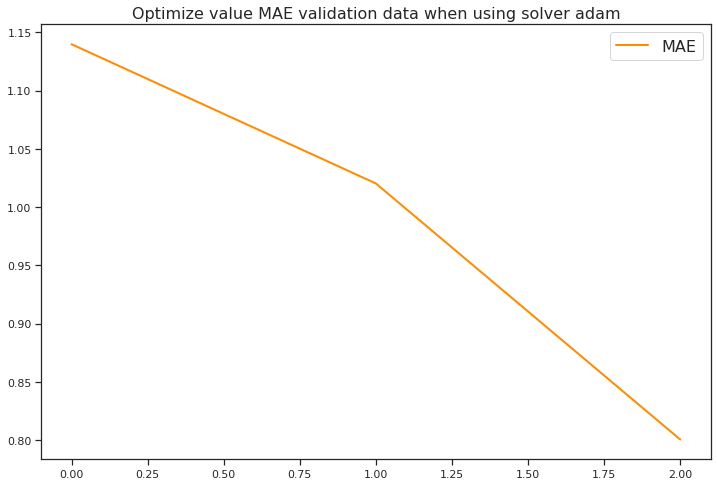



Using tanh activation function, with Gradient Descent Solver
Best rMSE for NN, using validation data: 1.0979721146937853
Best rSquared for NN, using validation data: -0.04135091478558972
Best MAE for NN, using validation data: 1.2055427646451429
Best MAE for NN, using holdout data: 1.6685054178504315


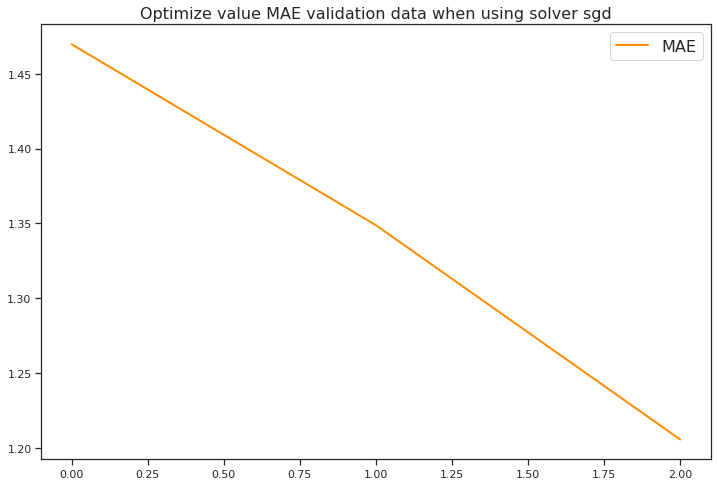

In [ ]:
findBestParametersNN(LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR)

## LOAD MODEL TỐI ƯU ĐÃ LƯU VÀ TÍNH TOÁN HIỆU NĂNG

### HIỆU NĂNG MODEL VỚI SOLVER LÀ ADAM

Predicted value when using best model rMSE (NN with Solver is adam): 
[ 1.24596841e+01  1.68703819e-01  1.12883702e+00  1.27638774e-01
  4.19786589e-01  9.97876201e-01  1.36985303e-02  3.02314768e+00
  5.63538041e-01  6.56514897e+00  2.82892965e-01 -3.71662743e-02
  4.98630592e-01 -4.12005368e-01  3.33930311e-01  1.29180046e+00
 -6.84524545e-02  7.20914929e-02  1.89708783e+01  1.75269405e+01
  3.10892895e-01  5.75794547e-01]
Actual value: 
[3.68     0.348067 2.09     0.245655 0.942803 0.220648 0.046815 3.84
 0.625696 1.95     0.443365 0.361564 1.08     2.2      0.371102 2.79
 0.062887 0.150417 3.2      9.77     0.396967 0.584651]


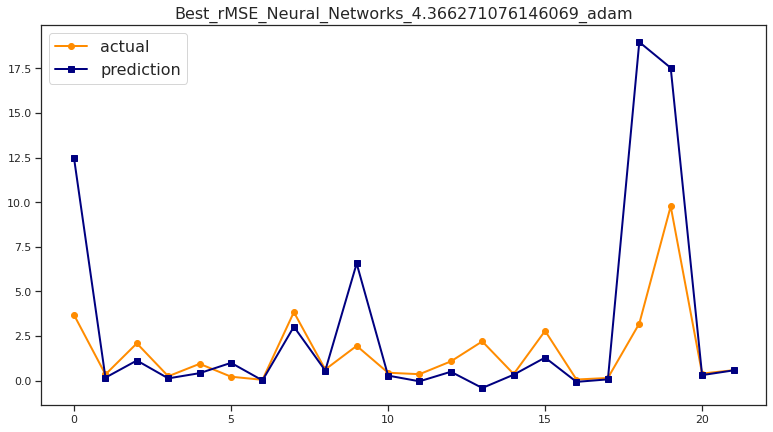

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


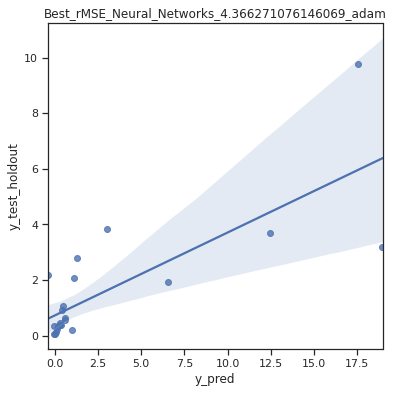

Predicted value when using best model R2 (NN with Solver is adam): 
[ 1.19189576e+01  1.16529773e-01  7.71912091e-01  2.08603175e-01
  3.99026178e-01  7.20482310e-01 -7.74145946e-02  3.17618026e+00
  7.28628539e-01  6.98953995e+00  3.42725237e-01  1.37706096e-01
  3.38286191e-01  1.02618505e+00  4.11376474e-01  4.56907822e-01
 -1.15706716e-02  2.31352794e-02  1.78843675e+01  1.75460945e+01
  5.98991019e-01  6.16487780e-01]
Actual value: 
[3.68     0.348067 2.09     0.245655 0.942803 0.220648 0.046815 3.84
 0.625696 1.95     0.443365 0.361564 1.08     2.2      0.371102 2.79
 0.062887 0.150417 3.2      9.77     0.396967 0.584651]


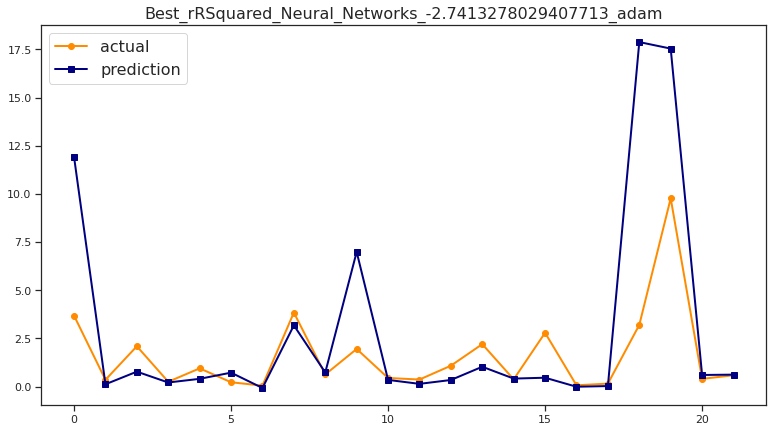

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


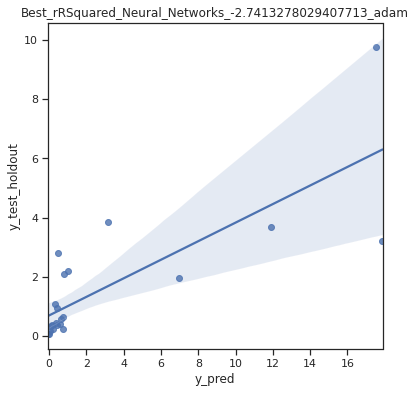

Predicted value when using best model MAE (NN with Solver is adam): 
[12.8350307   0.1141084   0.8444542   0.01963394  0.85718719  1.20880574
 -0.11579857  3.07174615  0.42213936  5.34770431  0.07615309 -0.03970079
  0.18316192  1.72071201  0.07284472  1.53977033 -0.14901917  0.02750071
 18.06169783 17.51649148  0.55513942  0.2540218 ]
Actual value: 
[3.68     0.348067 2.09     0.245655 0.942803 0.220648 0.046815 3.84
 0.625696 1.95     0.443365 0.361564 1.08     2.2      0.371102 2.79
 0.062887 0.150417 3.2      9.77     0.396967 0.584651]


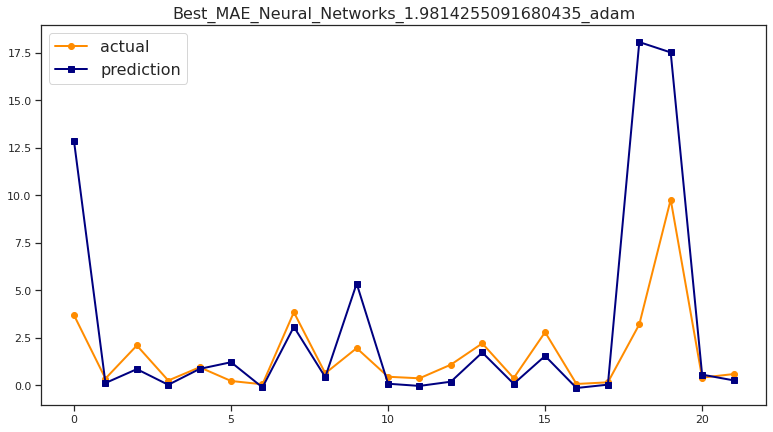

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


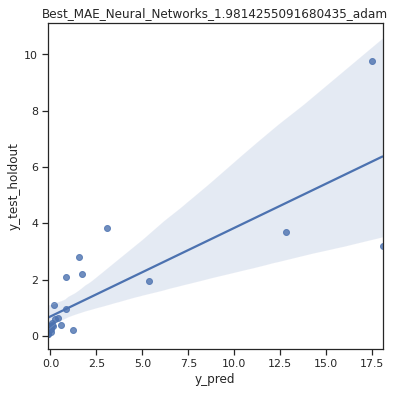

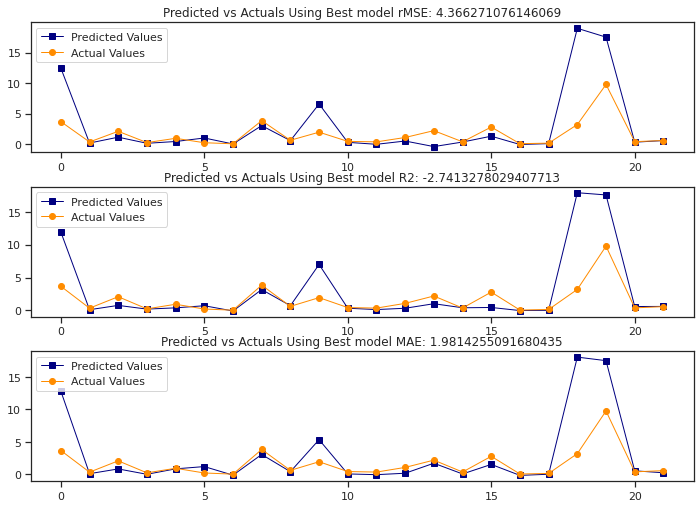

In [ ]:
fileName = "RESULT/" + "bestNNModel_" + str(LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR.name) + str(Solvers.adam.name) + ".sav"
bestNNModel_rMse = loadModel(fileName)
y_pred_holdout_rMSE_NN = None
y_pred_holdout_R2_NN = None
y_pred_holdout_MAE_NN = None

if(bestNNModel_rMse):
    y_pred_holdout_rMSE_NN = bestNNModel_rMse.predict(X_test_holdout)
    holdOutMeanSquaredError = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout_rMSE_NN))
    heading = "Best_rMSE_Neural_Networks_" + str(holdOutMeanSquaredError) + "_adam"
    print("Predicted value when using best model rMSE (NN with Solver is adam): ")
    print(y_pred_holdout_rMSE_NN)   
    print("Actual value: ")
    print(y_test_holdout)
    line_plot(y_test_holdout, y_pred_holdout_rMSE_NN, title = heading)
    plotExpectedVsPredictedOutput2(y_test_holdout, y_pred_holdout_rMSE_NN, heading, saveToFile)
    #print("Weights: ")
    #print(bestNNModel_rMse.coefs_)

## LOAD MOEL ĐÃ TỐI ƯU R2
fileName = "RESULT/" + "bestNNModel_" + str(LineaReggressionMetrics.R_SQUARED.name) + str(Solvers.adam.name)+ ".sav"
bestNNModel_rSquared = loadModel(fileName)
if(bestNNModel_rSquared):
    y_pred_holdout_R2_NN = bestNNModel_rSquared.predict(X_test_holdout)
    holdOutValidationR2Squared = r2_score(y_test_holdout, y_pred_holdout_R2_NN)
    heading = "Best_rRSquared_Neural_Networks_" + str(holdOutValidationR2Squared) + "_adam"
    print("Predicted value when using best model R2 (NN with Solver is adam): ")
    print(y_pred_holdout_R2_NN)   
    print("Actual value: ")
    print(y_test_holdout)
    line_plot(y_test_holdout, y_pred_holdout_R2_NN, title = heading)
    plotExpectedVsPredictedOutput2(y_test_holdout, y_pred_holdout_R2_NN, heading, saveToFile)
    #print("Weights: ")
    #print(bestNNModel_rSquared.coefs_)

## LOAD MOEL ĐÃ TỐI ƯU MAE
fileName = "RESULT/" + "bestNNModel_" + str(LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR.name) + str(Solvers.adam.name) +".sav"
bestNNModel_MAE = loadModel(fileName)
if(bestNNModel_MAE):
    y_pred_holdout_MAE_NN = bestNNModel_MAE.predict(X_test_holdout)
    holdOutMeanABError = mean_absolute_error(y_test_holdout, y_pred_holdout_MAE_NN)
    heading = "Best_MAE_Neural_Networks_" + str(holdOutMeanABError) + "_adam"
    print("Predicted value when using best model MAE (NN with Solver is adam): ")
    print(y_pred_holdout_MAE_NN)   
    print("Actual value: ")
    print(y_test_holdout)
    line_plot(y_test_holdout, y_pred_holdout_MAE_NN, title = heading)
    plotExpectedVsPredictedOutput2(y_test_holdout, y_pred_holdout_MAE_NN, heading, saveToFile)
    #print("Weights: ")
    #print(bestNNModel_MAE.coefs_)

plotResult(y_test_holdout, y_pred_holdout_rMSE_NN, y_pred_holdout_R2_NN, y_pred_holdout_MAE_NN, 
           rMSE = str(holdOutMeanSquaredError),R2 = str(holdOutValidationR2Squared), MAE = str(holdOutMeanABError))

### HIỆU NĂNG MODEL SỬ DỤNG SOLVER LÀ SGD

Predicted value when using best model rMSE (NN with Solver is sgd): 
[ 9.32772236e+00 -6.93499100e-03  1.95026765e+00  3.27001758e-01
  5.15449270e-01  1.12612794e+00  2.45435567e-01  5.05244843e+00
  4.26683683e-01  6.93323343e+00  5.53971388e-01  4.09009045e-01
 -3.36601964e-01  2.07540435e+00  6.67525387e-01  4.37855751e+00
  1.54520706e-01  1.16911885e-01  1.50888314e+01  1.09813399e+01
 -1.09108710e-01 -7.24233543e-02]
Actual value: 
[3.68     0.348067 2.09     0.245655 0.942803 0.220648 0.046815 3.84
 0.625696 1.95     0.443365 0.361564 1.08     2.2      0.371102 2.79
 0.062887 0.150417 3.2      9.77     0.396967 0.584651]


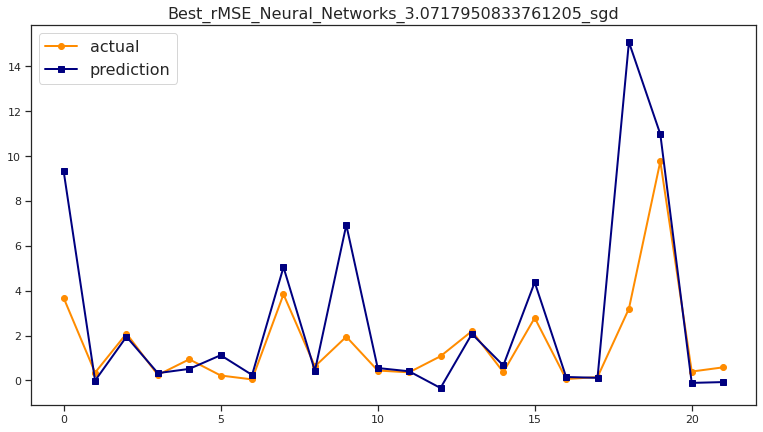

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


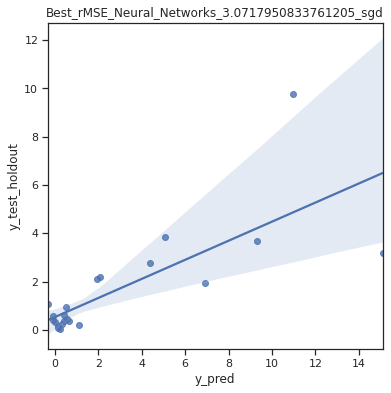

Predicted value when using best model R2 (NN with Solver is sgd): 
[2.22263235 2.22263235 2.22263235 2.22263235 0.4064807  0.4064807
 0.4064807  2.22263235 0.4064807  2.22263235 0.4064807  2.22263235
 2.22263235 0.4064807  0.4064807  2.22263235 2.22263235 0.4064807
 2.22263235 2.22263235 2.22263235 2.22263235]
Actual value: 
[3.68     0.348067 2.09     0.245655 0.942803 0.220648 0.046815 3.84
 0.625696 1.95     0.443365 0.361564 1.08     2.2      0.371102 2.79
 0.062887 0.150417 3.2      9.77     0.396967 0.584651]


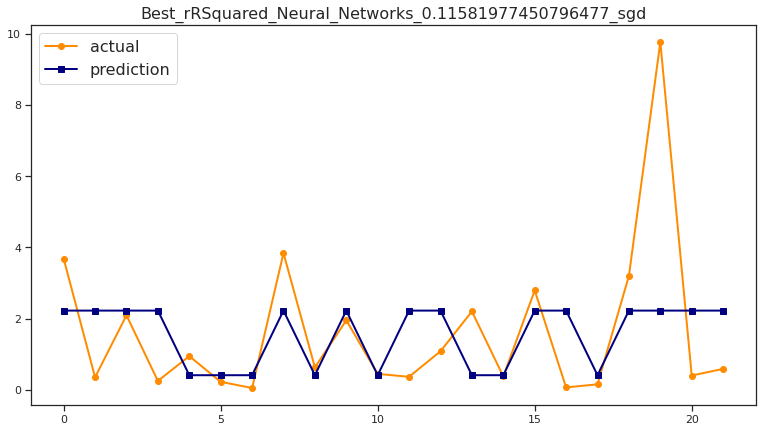

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


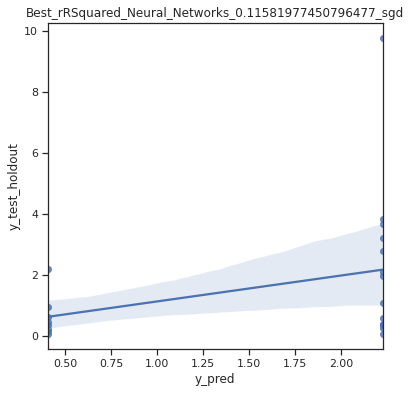

Predicted value when using best model MAE (NN with Solver is sgd): 
[ 8.43954428e+00  5.89398998e-01  4.04270129e+00 -2.97713947e-03
  1.17371538e+00  1.05760265e+00  6.94541983e-02  4.95221981e+00
  8.50462642e-01  6.41181554e+00 -1.00464090e-01  3.87180645e-02
  1.19127996e+00  1.27554720e+00 -7.18412833e-02  4.53996912e+00
 -6.40055857e-02 -5.91566762e-02  1.51879767e+01  1.43135027e+01
  1.26130594e+00 -2.03345458e-01]
Actual value: 
[3.68     0.348067 2.09     0.245655 0.942803 0.220648 0.046815 3.84
 0.625696 1.95     0.443365 0.361564 1.08     2.2      0.371102 2.79
 0.062887 0.150417 3.2      9.77     0.396967 0.584651]


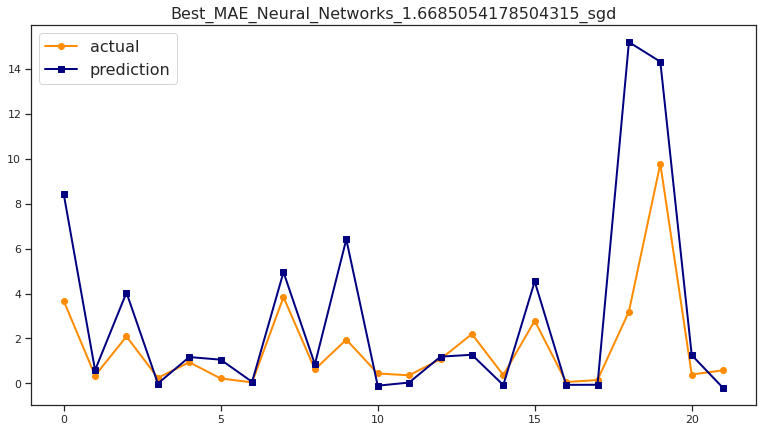

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


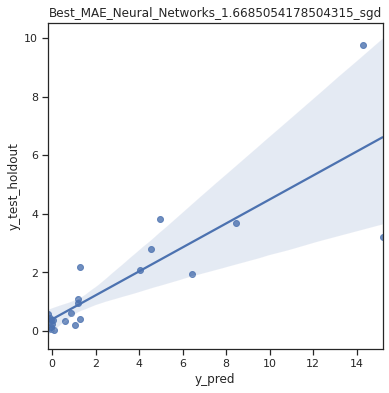

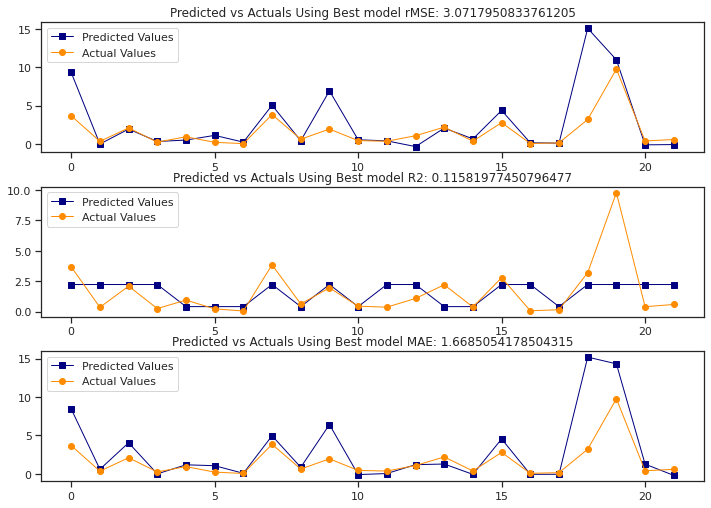

In [ ]:
fileName = "RESULT/" + "bestNNModel_" + str(LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR.name) + str(Solvers.sgd.name) + ".sav"
bestNNModel_rMse = loadModel(fileName)

if(bestNNModel_rMse):
    y_pred_holdout_rMSE_NN = bestNNModel_rMse.predict(X_test_holdout)
    holdOutMeanSquaredError = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout_rMSE_NN))
    heading = "Best_rMSE_Neural_Networks_" + str(holdOutMeanSquaredError) + "_sgd"
    print("Predicted value when using best model rMSE (NN with Solver is sgd): ")
    print(y_pred_holdout_rMSE_NN)   
    print("Actual value: ")
    print(y_test_holdout)
    line_plot(y_test_holdout, y_pred_holdout_rMSE_NN, title = heading)
    plotExpectedVsPredictedOutput2(y_test_holdout, y_pred_holdout_rMSE_NN, heading, saveToFile)
    #print("Weights: ")
    #print(bestNNModel_rMse.coefs_)

## LOAD MOEL ĐÃ TỐI ƯU R2
fileName = "RESULT/" + "bestNNModel_" + str(LineaReggressionMetrics.R_SQUARED.name) + str(Solvers.sgd.name)+ ".sav"
bestNNModel_rSquared = loadModel(fileName)
if(bestNNModel_rSquared):
    y_pred_holdout_R2_NN = bestNNModel_rSquared.predict(X_test_holdout)
    holdOutValidationR2Squared = r2_score(y_test_holdout, y_pred_holdout_R2_NN)
    heading = "Best_rRSquared_Neural_Networks_" + str(holdOutValidationR2Squared) + "_sgd"
    print("Predicted value when using best model R2 (NN with Solver is sgd): ")
    print(y_pred_holdout_R2_NN)   
    print("Actual value: ")
    print(y_test_holdout)
    line_plot(y_test_holdout, y_pred_holdout_R2_NN, title = heading)
    plotExpectedVsPredictedOutput2(y_test_holdout, y_pred_holdout_R2_NN, heading, saveToFile)
    #print("Weights: ")
    #print(bestNNModel_rSquared.coefs_)

## LOAD MOEL ĐÃ TỐI ƯU MAE
fileName = "RESULT/" + "bestNNModel_" + str(LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR.name) + str(Solvers.sgd.name) +".sav"
bestNNModel_MAE = loadModel(fileName)
if(bestNNModel_MAE):
    y_pred_holdout_MAE_NN = bestNNModel_MAE.predict(X_test_holdout)
    holdOutMeanABError = mean_absolute_error(y_test_holdout, y_pred_holdout_MAE_NN)
    heading = "Best_MAE_Neural_Networks_" + str(holdOutMeanABError) + "_sgd"
    print("Predicted value when using best model MAE (NN with Solver is sgd): ")
    print(y_pred_holdout_MAE_NN)   
    print("Actual value: ")
    print(y_test_holdout)
    line_plot(y_test_holdout, y_pred_holdout_MAE_NN, title = heading)
    plotExpectedVsPredictedOutput2(y_test_holdout, y_pred_holdout_MAE_NN, heading, saveToFile)
    #print("Weights: ")
    #print(bestNNModel_MAE.coefs_)

plotResult(y_test_holdout, y_pred_holdout_rMSE_NN, y_pred_holdout_R2_NN, y_pred_holdout_MAE_NN, 
           rMSE = str(holdOutMeanSquaredError),R2 = str(holdOutValidationR2Squared), MAE = str(holdOutMeanABError))

## SỬ DỤNG MODEL ĐỂ DỰ ĐOÁN GIÁ SAU 6 THÁNG

### DỰ ĐOÁN VỚI MODEL SỬ DỤNG SOLVER ADAM

Price of 3 ICO using best model rMSE
Predicted value of ICO 0x (real price: 1.08) after 6 months using best model rMSE:  [0.49863059]
Predicted value of ICO modum (real price: 2.79) after 6 months using best model rMSE:  [1.29180046]
Predicted value of ICO crypto20 (real price: 0.9786) after 6 months using best model rMSE:  [1.47269583]
Value rMSE, R2, MAE of best model rMSE
Value rMSE:  4.366271076146069
Value R2:  -3.1329065186925966
Value MAE:  2.0902777037592415


*************************************************************************************
Price of 3 ICO using best model R2
Predicted value of ICO 0x (real price: 1.08) after 6 months using best model R2:  [0.33828619]
Predicted value of ICO modum (real price: 2.79) after 6 months using best model R2:  [0.45690782]
Predicted value of ICO crypto20 (real price: 0.9786) after 6 months using best model R2:  [1.07707611]
Value rMSE, R2, MAE of best model R2
Value rMSE:  4.154280189279057
Value R2:  -2.7413278029407713
Value MAE: 

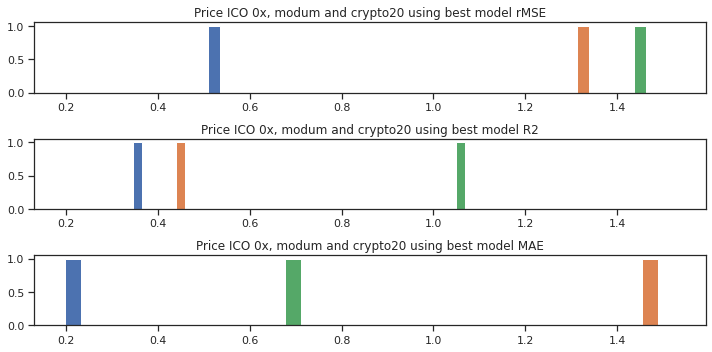

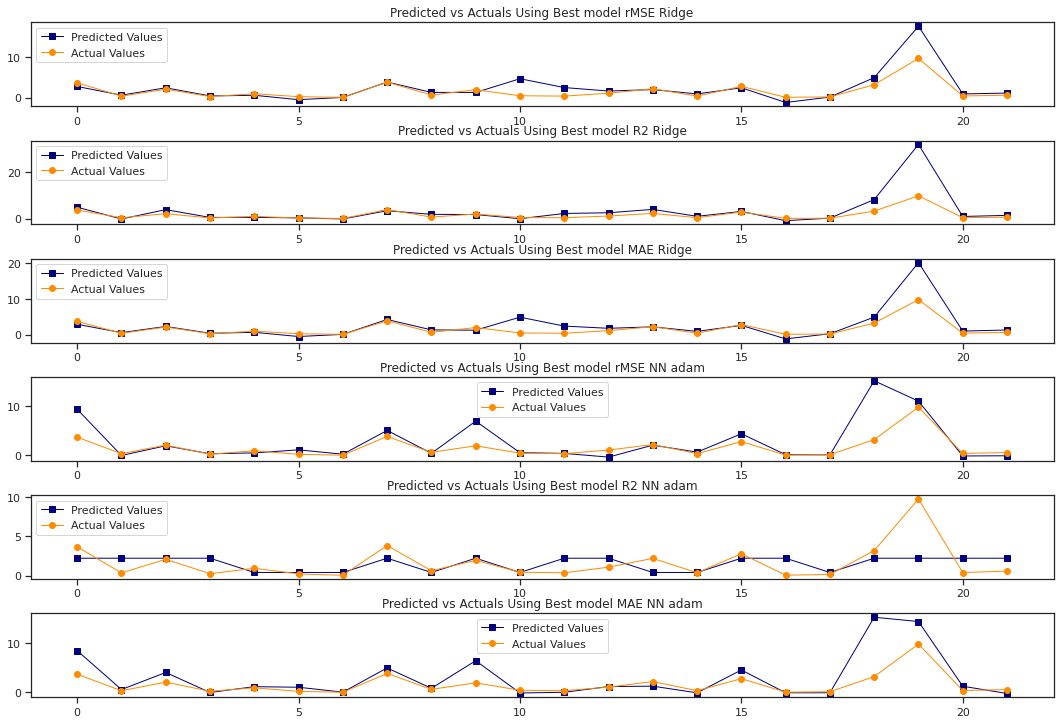

In [ ]:
# Load model with best rMse and make prediction
plotNNrMSE = []
plotNNR2 = []
plotNNMAE = []
fileName = "RESULT/" + "bestNNModel_" + str(LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR.name) + str(Solvers.adam.name) + ".sav"
bestNN = joblib.load(fileName)

fileName1 = "RESULT/" + "bestNNModel_" + str(LineaReggressionMetrics.R_SQUARED.name) + str(Solvers.adam.name)+ ".sav"
bestNNModel_rS = joblib.load(fileName1)

fileName2 = "RESULT/" + "bestNNModel_" + str(LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR.name) + str(Solvers.adam.name) +".sav"
bestNNModel_MAE = joblib.load(fileName2)

y_pred =  makePrediction(bestNN, ico_0x)
y_pred1 = makePrediction(bestNN, ico_modum)
y_pred2 = makePrediction(bestNN, ico_crypto20)
plotNNrMSE.append(y_pred)
plotNNrMSE.append(y_pred1)
plotNNrMSE.append(y_pred2)
y_pred_holdout = bestNN.predict(X_test_holdout)
R2coefficientHoldout = r2_score(y_test_holdout, y_pred_holdout)
rMeanSquaredErrorHoldout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout))
meanAbsoluteErrorHoldout= mean_absolute_error(y_test_holdout, y_pred_holdout)
print("Price of 3 ICO using best model rMSE")
print("Predicted value of ICO 0x (real price: 1.08) after 6 months using best model rMSE: ",y_pred)
print("Predicted value of ICO modum (real price: 2.79) after 6 months using best model rMSE: ",y_pred1)
print("Predicted value of ICO crypto20 (real price: 0.9786) after 6 months using best model rMSE: ",y_pred2)
print("Value rMSE, R2, MAE of best model rMSE")
print("Value rMSE: ", rMeanSquaredErrorHoldout)
print("Value R2: ", R2coefficientHoldout)
print("Value MAE: ", meanAbsoluteErrorHoldout) 
print("\n")       
print("*************************************************************************************")

y_pred3 = makePrediction(bestNNModel_rS, ico_0x)
y_pred4 = makePrediction(bestNNModel_rS, ico_modum)
y_pred5 = makePrediction(bestNNModel_rS, ico_crypto20)
plotNNR2.append(y_pred3)
plotNNR2.append(y_pred4)
plotNNR2.append(y_pred5)
y_pred_holdout = bestNNModel_rS.predict(X_test_holdout)
R2coefficientHoldout = r2_score(y_test_holdout, y_pred_holdout)
rMeanSquaredErrorHoldout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout))
meanAbsoluteErrorHoldout= mean_absolute_error(y_test_holdout, y_pred_holdout)
print("Price of 3 ICO using best model R2")
print("Predicted value of ICO 0x (real price: 1.08) after 6 months using best model R2: ",y_pred3)
print("Predicted value of ICO modum (real price: 2.79) after 6 months using best model R2: ",y_pred4)
print("Predicted value of ICO crypto20 (real price: 0.9786) after 6 months using best model R2: ",y_pred5)
print("Value rMSE, R2, MAE of best model R2")
print("Value rMSE: ", rMeanSquaredErrorHoldout)
print("Value R2: ", R2coefficientHoldout)
print("Value MAE: ", meanAbsoluteErrorHoldout) 
print("\n")       
print("*************************************************************************************")

y_pred3 = makePrediction(bestNNModel_MAE, ico_0x)
y_pred4 = makePrediction(bestNNModel_MAE, ico_modum)
y_pred5 = makePrediction(bestNNModel_MAE, ico_crypto20)
plotNNMAE.append(y_pred3)
plotNNMAE.append(y_pred4)
plotNNMAE.append(y_pred5)
y_pred_holdout = bestNNModel_MAE.predict(X_test_holdout)
R2coefficientHoldout = r2_score(y_test_holdout, y_pred_holdout)
rMeanSquaredErrorHoldout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout))
meanAbsoluteErrorHoldout= mean_absolute_error(y_test_holdout, y_pred_holdout)
print("Price of 3 ICO using best model MAE")
print("Predicted value of ICO 0x (real price: 1.08) after 6 months using best model MAE: ",y_pred3)
print("Predicted value of ICO modum (real price: 2.79) after 6 months using best model MAE: ",y_pred4)
print("Predicted value of ICO crypto20 (real price: 0.9786) after 6 months using best model MAE: ",y_pred5)
print("Value rMSE, R2, MAE of best model MAE")
print("Value rMSE: ", rMeanSquaredErrorHoldout)
print("Value R2: ", R2coefficientHoldout)
print("Value MAE: ", meanAbsoluteErrorHoldout)  
print("\n")       
print("*************************************************************************************")
plotPredicted(plotNNrMSE, plotNNR2, plotNNMAE)
plotResult2(y_test_holdout, y_pred_holdout_rMSE, y_pred_holdout_R2, y_pred_holdout_MAE, y_pred_holdout_rMSE_NN, 
                y_pred_holdout_R2_NN, y_pred_holdout_MAE_NN, solver = Solvers.adam)

### DỰ ĐOÁN VỚI MODEL SỬ DỤNG SOLVER SGD

Price of 3 ICO using best model rMSE
Predicted value of ICO 0x (real price: 1.08) after 6 months using best model rMSE:  [-0.33660196]
Predicted value of ICO modum (real price: 2.79) after 6 months using best model rMSE:  [4.37855751]
Predicted value of ICO crypto20 (real price: 0.9786) after 6 months using best model rMSE:  [1.24770733]
Value rMSE, R2, MAE of best model rMSE
Value rMSE:  3.0717950833761205
Value R2:  -1.0455903867212908
Value MAE:  1.4601200883142902


*************************************************************************************
Price of 3 ICO using best model R2
Predicted value of ICO 0x (real price: 1.08) after 6 months using best model R2:  [2.22263235]
Predicted value of ICO modum (real price: 2.79) after 6 months using best model R2:  [2.22263235]
Predicted value of ICO crypto20 (real price: 0.9786) after 6 months using best model R2:  [2.22263235]
Value rMSE, R2, MAE of best model R2
Value rMSE:  2.0195439217673647
Value R2:  0.11581977450796477
Value MA

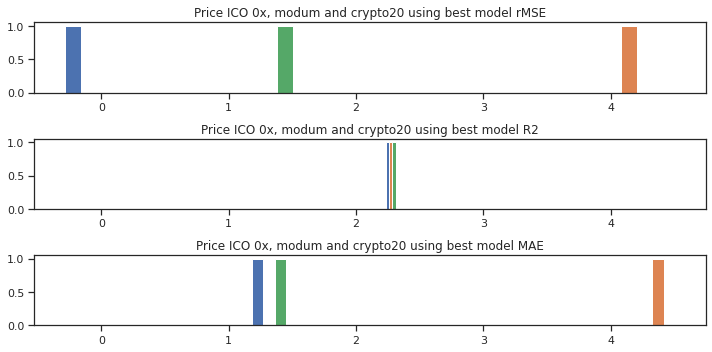

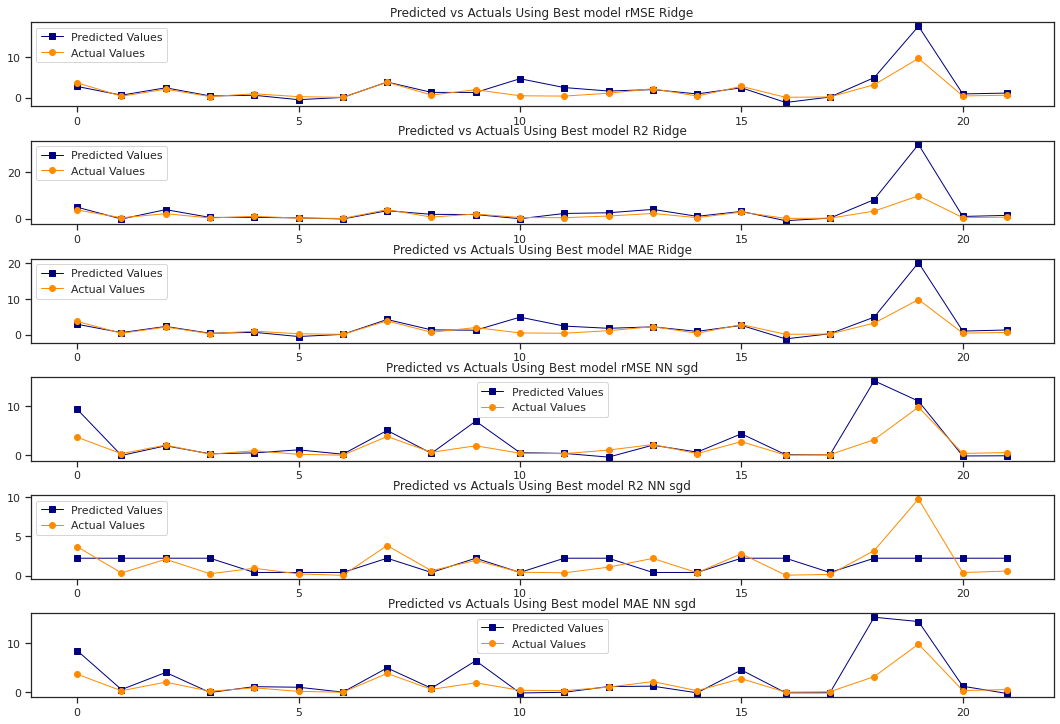

In [ ]:
# Load model with best rMse and make prediction
plotNNrMSE = []
plotNNR2 = []
plotNNMAE = []
fileName = "RESULT/" + "bestNNModel_" + str(LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR.name) + str(Solvers.sgd.name) + ".sav"
bestNN = joblib.load(fileName)

fileName1 = "RESULT/" + "bestNNModel_" + str(LineaReggressionMetrics.R_SQUARED.name) + str(Solvers.sgd.name)+ ".sav"
bestNNModel_rS = joblib.load(fileName1)

fileName2 = "RESULT/" + "bestNNModel_" + str(LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR.name) + str(Solvers.sgd.name) +".sav"
bestNNModel_MAE = joblib.load(fileName2)

y_pred =  makePrediction(bestNN, ico_0x)
y_pred1 = makePrediction(bestNN, ico_modum)
y_pred2 = makePrediction(bestNN, ico_crypto20)
plotNNrMSE.append(y_pred)
plotNNrMSE.append(y_pred1)
plotNNrMSE.append(y_pred2)
y_pred_holdout = bestNN.predict(X_test_holdout)
R2coefficientHoldout = r2_score(y_test_holdout, y_pred_holdout)
rMeanSquaredErrorHoldout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout))
meanAbsoluteErrorHoldout= mean_absolute_error(y_test_holdout, y_pred_holdout)
print("Price of 3 ICO using best model rMSE")
print("Predicted value of ICO 0x (real price: 1.08) after 6 months using best model rMSE: ",y_pred)
print("Predicted value of ICO modum (real price: 2.79) after 6 months using best model rMSE: ",y_pred1)
print("Predicted value of ICO crypto20 (real price: 0.9786) after 6 months using best model rMSE: ",y_pred2)
print("Value rMSE, R2, MAE of best model rMSE")
print("Value rMSE: ", rMeanSquaredErrorHoldout)
print("Value R2: ", R2coefficientHoldout)
print("Value MAE: ", meanAbsoluteErrorHoldout) 
print("\n")       
print("*************************************************************************************")

y_pred3 = makePrediction(bestNNModel_rS, ico_0x)
y_pred4 = makePrediction(bestNNModel_rS, ico_modum)
y_pred5 = makePrediction(bestNNModel_rS, ico_crypto20)
plotNNR2.append(y_pred3)
plotNNR2.append(y_pred4)
plotNNR2.append(y_pred5)
y_pred_holdout = bestNNModel_rS.predict(X_test_holdout)
R2coefficientHoldout = r2_score(y_test_holdout, y_pred_holdout)
rMeanSquaredErrorHoldout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout))
meanAbsoluteErrorHoldout= mean_absolute_error(y_test_holdout, y_pred_holdout)
print("Price of 3 ICO using best model R2")
print("Predicted value of ICO 0x (real price: 1.08) after 6 months using best model R2: ",y_pred3)
print("Predicted value of ICO modum (real price: 2.79) after 6 months using best model R2: ",y_pred4)
print("Predicted value of ICO crypto20 (real price: 0.9786) after 6 months using best model R2: ",y_pred5)
print("Value rMSE, R2, MAE of best model R2")
print("Value rMSE: ", rMeanSquaredErrorHoldout)
print("Value R2: ", R2coefficientHoldout)
print("Value MAE: ", meanAbsoluteErrorHoldout) 
print("\n")       
print("*************************************************************************************")

y_pred3 = makePrediction(bestNNModel_MAE, ico_0x)
y_pred4 = makePrediction(bestNNModel_MAE, ico_modum)
y_pred5 = makePrediction(bestNNModel_MAE, ico_crypto20)
plotNNMAE.append(y_pred3)
plotNNMAE.append(y_pred4)
plotNNMAE.append(y_pred5)
y_pred_holdout = bestNNModel_MAE.predict(X_test_holdout)
R2coefficientHoldout = r2_score(y_test_holdout, y_pred_holdout)
rMeanSquaredErrorHoldout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout))
meanAbsoluteErrorHoldout= mean_absolute_error(y_test_holdout, y_pred_holdout)
print("Price of 3 ICO using best model MAE")
print("Predicted value of ICO 0x (real price: 1.08) after 6 months using best model MAE: ",y_pred3)
print("Predicted value of ICO modum (real price: 2.79) after 6 months using best model MAE: ",y_pred4)
print("Predicted value of ICO crypto20 (real price: 0.9786) after 6 months using best model MAE: ",y_pred5)
print("Value rMSE, R2, MAE of best model MAE")
print("Value rMSE: ", rMeanSquaredErrorHoldout)
print("Value R2: ", R2coefficientHoldout)
print("Value MAE: ", meanAbsoluteErrorHoldout)  
print("\n")       
print("*************************************************************************************")
plotPredicted(plotNNrMSE, plotNNR2, plotNNMAE)
plotResult2(y_test_holdout, y_pred_holdout_rMSE, y_pred_holdout_R2, y_pred_holdout_MAE, y_pred_holdout_rMSE_NN, 
                y_pred_holdout_R2_NN, y_pred_holdout_MAE_NN, solver = Solvers.sgd)

## DOWNLOAD CÁC FILE


In [ ]:
!zip -r /content/IMAGE_LINE_PLOT.zip /content/IMAGE_LINE_PLOT
files.download("/content/IMAGE_LINE_PLOT.zip")

!zip -r /content/IMAGE_RESULT.zip /content/IMAGE_RESULT
files.download("/content/IMAGE_RESULT.zip")

!zip -r /content/IMAGE_SCATTER.zip /content/IMAGE_SCATTER
files.download("/content/IMAGE_SCATTER.zip")

!zip -r /content/RESULT.zip /content/RESULT
files.download("/content/RESULT.zip")

!zip -r /content/LINE_PLOT_3.zip /content/LINE_PLOT_3
files.download("/content/LINE_PLOT_3.zip")

!zip -r /content/LINE_PLOT_6.zip /content/LINE_PLOT_6
files.download("/content/LINE_PLOT_6.zip")

  adding: content/IMAGE_LINE_PLOT/ (stored 0%)
  adding: content/IMAGE_LINE_PLOT/Test Error: 412.6222499818709.png (deflated 29%)
  adding: content/IMAGE_LINE_PLOT/Best_MAE_Ridge_Regression_1.211385330600619.png (deflated 24%)
  adding: content/IMAGE_LINE_PLOT/Best_MAE_Neural_Networks_1.6685054178504315_sgd.png (deflated 21%)
  adding: content/IMAGE_LINE_PLOT/Best_rMSE_Neural_Networks_3.0717950833761205_sgd.png (deflated 20%)
  adding: content/IMAGE_LINE_PLOT/Best_MAE_Neural_Networks_1.9814255091680435_adam.png (deflated 22%)
  adding: content/IMAGE_LINE_PLOT/Best_rMSE_Neural_Networks_4.366271076146069_adam.png (deflated 22%)
  adding: content/IMAGE_LINE_PLOT/Best_rRSquared_Neural_Networks_-2.7413278029407713_adam.png (deflated 22%)
  adding: content/IMAGE_LINE_PLOT/Best_rRSquared_Ridge_Regression_-4.206633602661219.png (deflated 25%)
  adding: content/IMAGE_LINE_PLOT/Best_rMSE_Ridge_Regression_2.0893132337849605.png (deflated 23%)
  adding: content/IMAGE_LINE_PLOT/Best_rRSquared_Neura

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/IMAGE_RESULT/ (stored 0%)
  adding: content/IMAGE_RESULT/Test Error: 412.6222499818709.png (deflated 17%)
  adding: content/IMAGE_RESULT/Best_MAE_Ridge_Regression_1.211385330600619.png (deflated 14%)
  adding: content/IMAGE_RESULT/Best_MAE_Neural_Networks_1.6685054178504315_sgd.png (deflated 14%)
  adding: content/IMAGE_RESULT/Best_rMSE_Neural_Networks_3.0717950833761205_sgd.png (deflated 15%)
  adding: content/IMAGE_RESULT/Best_MAE_Neural_Networks_1.9814255091680435_adam.png (deflated 15%)
  adding: content/IMAGE_RESULT/Best_rMSE_Neural_Networks_4.366271076146069_adam.png (deflated 14%)
  adding: content/IMAGE_RESULT/Best_rRSquared_Neural_Networks_-2.7413278029407713_adam.png (deflated 15%)
  adding: content/IMAGE_RESULT/Best_rRSquared_Ridge_Regression_-4.206633602661219.png (deflated 16%)
  adding: content/IMAGE_RESULT/Best_rMSE_Ridge_Regression_2.0893132337849605.png (deflated 14%)
  adding: content/IMAGE_RESULT/Best_rRSquared_Neural_Networks_0.11581977450796477_sg

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/IMAGE_SCATTER/ (stored 0%)
  adding: content/IMAGE_SCATTER/social_k_vs_Price_scatter_plot.png (deflated 14%)
  adding: content/IMAGE_SCATTER/market_cap_usd_vs_Price_scatter_plot.png (deflated 14%)
  adding: content/IMAGE_SCATTER/eth_price_launch_vs_Price_scatter_plot.png (deflated 14%)
  adding: content/IMAGE_SCATTER/total_24h_vs_Price_scatter_plot.png (deflated 14%)
  adding: content/IMAGE_SCATTER/price_usd_vs_Price_scatter_plot.png (deflated 15%)
  adding: content/IMAGE_SCATTER/month_vs_Price_scatter_plot.png (deflated 14%)
  adding: content/IMAGE_SCATTER/country_vs_Price_scatter_plot.png (deflated 13%)
  adding: content/IMAGE_SCATTER/usd_raised_vs_Price_scatter_plot.png (deflated 14%)
  adding: content/IMAGE_SCATTER/price_btc_vs_Price_scatter_plot.png (deflated 14%)
  adding: content/IMAGE_SCATTER/available_supply_vs_Price_scatter_plot.png (deflated 14%)
  adding: content/IMAGE_SCATTER/day_vs_Price_scatter_plot.png (deflated 14%)
  adding: content/IMAGE_SCATTER/btc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/RESULT/ (stored 0%)
  adding: content/RESULT/bestNNModel_ROOT_MEAN_SQUARED_ERRORadam.sav (deflated 4%)
  adding: content/RESULT/bestRegressionModel_Ridge_ROOT_MEAN_SQUARED_ERROR.sav (deflated 14%)
  adding: content/RESULT/bestRegressionModel_Ridge_MEAN_ABSOLUTE_ERROR.sav (deflated 14%)
  adding: content/RESULT/bestNNModel_MEAN_ABSOLUTE_ERRORsgd.sav (deflated 4%)
  adding: content/RESULT/bestNNModel_R_SQUAREDadam.sav (deflated 4%)
  adding: content/RESULT/bestNNModel_R_SQUAREDsgd.sav (deflated 38%)
  adding: content/RESULT/bestRegressionModel_Ridge_R_SQUARED.sav (deflated 15%)
  adding: content/RESULT/bestNNModel_MEAN_ABSOLUTE_ERRORadam.sav (deflated 4%)
  adding: content/RESULT/bestNNModel_ROOT_MEAN_SQUARED_ERRORsgd.sav (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/LINE_PLOT_3/ (stored 0%)
  adding: content/LINE_PLOT_3/PLOT_RESULT.png (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/LINE_PLOT_6/ (stored 0%)
  adding: content/LINE_PLOT_6/PLOT_RESULT.png (deflated 11%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>